**Author:** Mathurin Choblet (mchoblet@uliege.be)

**Date:** 25.11.2025



* Do total scatter plots and statistics for full products:
    * Global products
    * Atlantic products
    * Meditterenean products

* in the scatterplots I should indicate the region.

However, I realize that just displaying the regional products from CMEMS should not be very interesting, as the results should be very close -> not a good story:

I come to the final structure:

1. Global Cruise: 6 subplots (OLCI 300m and 4km resampled in the same plot)

2. Norwegian Sea: 6 Subplots as well, because we use the same global products (no acrtic sea ocean colour product, at least for 2025. CMEMS product stops in December 2024)

3. Atlantic: 9 Subplots, because we have 4 additional products (at 300 and 1km resolution), atlantic olci and global olci are exactly the same (?). In terms of statistcs I should see this -> exclude the 9subplot then, however l3/l4 atlantic product different (at 1km), I could also include it in the 6 subplots.

4. Med. Sea: 9. Subplots, this time really, because the cmems products use a different algorithm (and significantly remove the bias. having the same axis limits will help in seeing that the adapted algorithm works)

Downsampling OLCI products to higher resolution (1km,4km) -> used to do that, as its a bit 'manual', leave that out and instead use the downsampled products available via CMEMS

In [1]:
import xarray as xr
import glob
import numpy as np
import os, re
import matplotlib.pyplot as plt
import datetime
import matplotlib.gridspec as GridSpec
from matplotlib.ticker import FuncFormatter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from scipy import stats


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import seaborn as sns
import matplotlib.patches as patches
import pandas as pd
sns.set_context('talk')
land = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])


import warnings

# Suppress the specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Degrees of freedom <= 0 for slice')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in scalar divide')

# Load Data

In [2]:
%%time

l4=xr.open_dataset('/home/mathu/otc25_project/DATA/copernicus-data/chl_gapfree_OTC25.nc')
l3_olci=xr.open_dataset('/home/mathu/otc25_project/DATA/copernicus-data/chl_l3_OLCI_300m_OTC25.nc')
l3_chl=xr.open_dataset('/home/mathu/otc25_project/DATA/copernicus-data/chl_l3_OTC25.nc')

modis=sorted(glob.glob('/home/mathu/otc25_project/AQUA_MODIS/*DAY*4km.nc'))
PACE=sorted(glob.glob('/home/mathu/otc25_project/PACE/*DAY*4km*.nc'))

def preprocess(ds):
    path=ds.encoding['source']
    #ds=ds.expand_dims('time')
    date=os.path.basename(path).split('.')[1]
    time= pd.to_datetime(f"{date[:4]}-{date[4:6]}-{date[6:8]}")
    ds=ds.assign_coords(time=[time])
    ds=ds.sortby('lat')
    ds=ds.sel(lat=slice(18,71),lon=slice(-28,35))
    return ds

pace=xr.open_mfdataset(PACE,preprocess=preprocess).load()
modis=xr.open_mfdataset(modis,preprocess=preprocess).load()

oc_cci=xr.open_dataset('/home/mathu/otc25_project/CCI_ALL-v6.0-DAILY.nc')

gc_atl_olci_l3=xr.open_dataset('copernicus-data/cmems_obs-oc_atl_bgc-plankton_nrt_l3-olci-300m_P1D_multi-vars_28.00W-13.00E_35.00N-66.00N_2025-04-20-2025-06-04.nc')
gc_atl_l3=xr.open_dataset('copernicus-data/cmems_obs-oc_atl_bgc-plankton_my_l3-multi-1km_P1D_multi-vars_27.99W-12.99E_35.01N-65.99N_2025-04-20-2025-06-04.nc')
gc_atl_l4=xr.open_dataset('copernicus-data/cmems_obs-oc_atl_bgc-plankton_my_l4-gapfree-multi-1km_P1D_multi-vars_27.99W-12.99E_35.01N-65.99N_2025-04-20-2025-06-04.nc')

gc_med_l3=xr.open_dataset('copernicus-data/cmems_obs-oc_med_bgc-plankton_my_l3-multi-1km_P1D_multi-vars_5.99W-17.99E_35.01N-45.99N_2025-04-20-2025-06-04.nc')
gc_med_l4=xr.open_dataset('copernicus-data/cmems_obs-oc_med_bgc-plankton_my_l4-gapfree-multi-1km_P1D_CHL_5.99W-17.99E_35.01N-45.99N_2025-04-20-2025-06-04.nc')


CPU times: user 10.9 s, sys: 2.27 s, total: 13.2 s
Wall time: 10.8 s


In [3]:
gc_olci_4km=xr.open_dataset('/home/mathu/otc25_project/copernicus-data/cmems_obs-oc_glo_bgc-plankton_my_l3-olci-4km_P1D_multi-vars_27.98W-17.98E_35.02N-70.98N_2025-04-20-2025-06-04.nc')
gc_olci_atl_1km=xr.open_dataset('/home/mathu/otc25_project/copernicus-data/cmems_obs-oc_atl_bgc-plankton_my_l3-olci-1km_P1D_multi-vars_27.99W-12.99E_35.01N-65.99N_2025-04-20-2025-06-04.nc')

In [4]:
gc_med_olci_l3=xr.open_dataset('/home/mathu/otc25_project/copernicus-data/cmems_obs-oc_med_bgc-plankton_nrt_l3-olci-300m_P1D_CHL_6.00W-18.00E_35.00N-46.00N_2025-04-20-2025-06-04.nc')

In [5]:
#ASSEMBLE INLINE SYSTEM DATA
df1=pd.read_csv('/home/mathu/prod/Leg03/OneOcean_InLine_ACS_20250423_20250505_Products_full_Leg03_v20250530.csv')[['dt','lat','lon','Chl_lineheight']]
df2=pd.read_csv('/home/mathu/prod/Leg04/OneOcean_InLine_ACS_20250508_20250602_Products_Leg04_v20250603.csv')[['dt','lat','lon','Chl_lineheight']]

times=np.concatenate([df1['dt'].values,df2['dt'].values])
vals=np.concatenate([df1['Chl_lineheight'],df2['Chl_lineheight']])
lats=np.concatenate([df1['lat'],df2['lat']])
lons=np.concatenate([df1['lon'],df2['lon']])
inline=xr.Dataset(data_vars={'CHL':('time',vals),'lat':('time',lats),'lon':('time',lons)},coords={'time':times})

inline['time']=pd.to_datetime(inline['time'])
#this will help in having the full timeline
inline_res=inline.resample(time='5min').mean()

In [6]:
time_mask=(inline['time'].dt.hour>=10) & (inline['time'].dt.hour<=14)

In [7]:
inline_masked=xr.where(time_mask,inline,np.nan)

# Satellite matchup

In [8]:
def match_satellite(ds=pace,
    lat_var='lat',
    lon_var='lon',
    chlor_val='chlor_a'):

    def bw_filter(x):
        mean=np.nanmean(x)
        std=np.nanstd(x)
    
        mask=(x>(x-1.5*std)) & (x<(x+1.5*std)) & (~np.isnan(x))
        x_masked=x[mask]
    
        mean_filt=np.mean(x_masked)
        std_filt=np.std(x_masked)
    
        #coefficient of variation
        cv=std_filt/mean_filt
        
        return mean_filt,std_filt,cv
    
    #inline system replace latitudes and longitudes
    #inline_p=inline.copy(deep=True)
    
    lat_grid=ds[lat_var].values
    lon_grid=ds[lon_var].values
    in_lat=inline.lat.values
    in_lon=inline.lon.values
    
    #select nearest longitude
    lons=lon_grid[np.argmin(np.abs((in_lon[:,None]-lon_grid)),axis=1)]
    lats=lat_grid[np.argmin(np.abs((in_lat[:,None]-lat_grid)),axis=1)]
    
    #inline system replace latitudes and longitudes
    inline_p=inline_masked.copy(deep=True)
    inline_p['lat'].data=lats
    inline_p['lon'].data=lons
    inline_p=inline_p.assign_coords({'lat':inline_p['lat'],'lon':inline_p['lon']})
    inline_p['time']=pd.to_datetime(inline_p['time'].values)
    
    unique_pos=np.unique(list(zip(lats,lons)),axis=0)
    
    times=[]
    vals=[]
    num=[]
    
    for p in unique_pos:
        mask=(inline_p.lat==p[0]) & (inline_p.lon==p[1]) 
        select=inline_p.isel(time=mask)
        mask2=~np.isnan(select['CHL'])
        select2=select.isel(time=mask2)
        num.append(np.count_nonzero(mask2))
        times.append(select['time'].mean().values)
        vals.append(select['CHL'].mean('time').values.item())
    
    #binned
    inline_b=xr.DataArray(vals,coords={'time':times,'lat':('time',unique_pos[:,0]),'lon':('time',unique_pos[:,1])},dims='time')
    
    #APPROACH: COMPUTE EVERYTHING AND SELECT LATER (e.g. with filt)
    sat_vals=[]
    sat_vals_mean=[]
    sat_vals_med=[]
    sat_vals_std=[]
    filt_m=[]
    filt_std=[]
    filt_cv=[]
    counts=[]
    
    time2=[]
    for i,p in enumerate(unique_pos):
        time=ds.time.sel(time=times[i],method='nearest').values
        time2.append(time)
        lat_i=np.argwhere(ds[lat_var].values==p[0]).item()
        lon_i=np.argwhere(ds[lon_var].values==p[1]).item()
    
        sat_vals.append(ds[chlor_val].isel({lat_var:lat_i,lon_var:lon_i}).sel({'time':time}).values.item())
        
        selec=ds[chlor_val].isel({lat_var:slice(lat_i-1,lat_i+2),lon_var:slice(lon_i-1,lon_i+2)}).sel({'time':time})
    
        count=np.count_nonzero(~np.isnan(selec))
        counts.append(count)
        
        if count>=5:
            sat_vals_mean.append(selec.mean().values.item())
            sat_vals_med.append(selec.median().values.item())
            sat_vals_std.append(selec.std().values.item())
            m,s,cv=bw_filter(selec.values.reshape(-1))
            filt_m.append(m)
            filt_std.append(s)
            filt_cv.append(cv)
        else:
            sat_vals_mean.append(np.nan)
            sat_vals_med.append(np.nan)
            sat_vals_std.append(np.nan)
            m,s,cv=bw_filter(selec.values.reshape(-1))
            filt_m.append(np.nan)
            filt_std.append(np.nan)
            filt_cv.append(np.nan)
    
    dicti={
        'sat_vals':np.array(sat_vals),
        'sat_vals_mean':np.array(sat_vals_mean),
        'sat_vals_med':np.array(sat_vals_med),
        'sat_vals_std':np.array(sat_vals_std),
        'filt_m':np.array(filt_m),
        'filt_std':np.array(filt_std),
        'filt_cv':np.array(filt_cv),
        'counts':np.array(counts),
    
    }
    time=np.array(time2)
    
    dicti_ds={}
    for k,v in dicti.items():
        ds=xr.DataArray(v,coords={'time':time,'lat':('time',unique_pos[:,0]),'lon':('time',unique_pos[:,1])},dims='time')
        dicti_ds[k]=ds
    
    dataset=xr.Dataset(dicti_ds)    

    return dataset,inline_b

In [9]:
%%time
ds_pace,inline_b_pace=match_satellite(pace)
ds_modisa,inline_b_modisa=match_satellite(modis)
ds_l3,inline_b_l3=match_satellite(l3_chl,lat_var='latitude',lon_var='longitude',chlor_val='CHL')
ds_l3olci,inline_b_olci=match_satellite(l3_olci,lat_var='latitude',lon_var='longitude',chlor_val='CHL')
ds_l4,inline_b_l4=match_satellite(l4,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

ds_oc_cci,inline_oc_cci=match_satellite(oc_cci)
ds_gc_atl_olci,inline_gc_atl_olci=match_satellite(gc_atl_olci_l3,lat_var='latitude',lon_var='longitude',chlor_val='CHL')
ds_gc_atl_l3,inline_gc_atl_l3=match_satellite(gc_atl_l3,lat_var='latitude',lon_var='longitude',chlor_val='CHL')
ds_gc_atl_l4,inline_gc_atl_l4=match_satellite(gc_atl_l4,lat_var='latitude',lon_var='longitude',chlor_val='CHL')
ds_gc_med_l3,inline_gc_med_l3=match_satellite(gc_med_l3,lat_var='latitude',lon_var='longitude',chlor_val='CHL')
ds_gc_med_l4,inline_gc_med_l4=match_satellite(gc_med_l4,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

CPU times: user 4min 40s, sys: 4.25 s, total: 4min 44s
Wall time: 4min 46s


In [10]:
#lets free up some RAM to not crash the system (htop before: 9.42GB , htop after: 8.85gb)
del pace; del modis;  del l4; del oc_cci; del gc_med_l4; del gc_atl_l4;

In [11]:
ds_gc_med_olci_l3,inline_gc_med_olci_l3=match_satellite(gc_med_olci_l3,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

In [12]:
%%time
#resampling products

#olci med to 1km
#make sure to drop time variable 
#med_olci_interp=gc_med_olci_l3.interp_like(gc_med_l3.isel(time=0).drop_vars('time'),method='linear')
#med_olci_interp=gc_med_olci_l3.interp(latitude=gc_med_l3['latitude'],longitude=gc_med_l3['longitude'])

#ds_gc_med_olci_l3_interp,inline_gc_med_olci_l3_interp=match_satellite(med_olci_interp,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

#during interpolation, the ram goes up and up and up ... (until ... 40 GB)
#this was with interp_like, which would also interpolate in time, we neither need nor want that,
#-> drop the time variable
#del med_olci_interp; del gc_med_l3; del gc_med_olci_l3;

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.29 μs


In [13]:
%%time

#hot fix to avoid ram blow up: chunk in time before doing interpolation, then load

#olci atlantic to 1km

#atl_olci_interp=gc_atl_olci_l3.interp_like(gc_atl_l3.isel(time=0).drop_vars('time'),method='linear')
#2 id interpolations?
#atl_olci_interp=gc_atl_olci_l3.chunk({"time": 1, "latitude": -1, "longitude": -1}).interp(latitude=gc_atl_l3['latitude'],longitude=gc_atl_l3['longitude']).load()
#ds_gc_atl_olci_l3_interp,inline_gc_atl_olci_l3_interp=match_satellite(atl_olci_interp,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

#del gc_atl_l3; del gc_atl_olci_l3; del atl_olci_interp

CPU times: user 7 μs, sys: 0 ns, total: 7 μs
Wall time: 11.7 μs


In [12]:
ds_gc_atl_olci_l3_interp,inline_gc_atl_olci_l3_interp=match_satellite(gc_olci_atl_1km,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

In [13]:
"""
%%time
#olci global to 4km

#l3_olci_interp=l3_olci.interp_like(l3_chl.isel(time=0).drop_vars('time'),method='linear')
l3_olci_interp=l3_olci.chunk({"time": 1, "latitude": -1, "longitude": -1}).interp(latitude=l3_chl['latitude'],longitude=l3_chl['longitude']).load()

ds_gc_olci_l3_interp,inline_gc_olci_l3_interp=match_satellite(l3_olci_interp,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

del l3_chl; del l3_olci_interp; del l3_olci;

"""

'\n%%time\n#olci global to 4km\n\n#l3_olci_interp=l3_olci.interp_like(l3_chl.isel(time=0).drop_vars(\'time\'),method=\'linear\')\nl3_olci_interp=l3_olci.chunk({"time": 1, "latitude": -1, "longitude": -1}).interp(latitude=l3_chl[\'latitude\'],longitude=l3_chl[\'longitude\']).load()\n\nds_gc_olci_l3_interp,inline_gc_olci_l3_interp=match_satellite(l3_olci_interp,lat_var=\'latitude\',lon_var=\'longitude\',chlor_val=\'CHL\')\n\ndel l3_chl; del l3_olci_interp; del l3_olci;\n\n'

In [14]:
ds_gc_olci_l3_interp,inline_gc_olci_l3_interp=match_satellite(gc_olci_4km,lat_var='latitude',lon_var='longitude',chlor_val='CHL')

# Scatterplots

# Global scatterplot

# Norwegian Sea (no regional products)

# North Atlantic (+4 regional products, partially superflous for olci (giving exactly the same stats))

In [15]:
def valid_pos(a):
    """Return finite, positive values from array-like (for log10)."""
    a = np.asarray(a)
    return a[np.isfinite(a) & (a > 0)]

def paired_log10(x_sat, y_inline):
    #note: I have reversed the order in the plotting code (x-axis: inline system, y-axis: satellite data)
    """Return matched, finite log10 pairs (x_log, y_log)."""
    x = valid_pos(x_sat)
    y = valid_pos(y_inline)
    # assume arrays are already matched by index/time; align by mask of finite>0 on both
    m = np.isfinite(x_sat) & (x_sat > 0) & np.isfinite(y_inline) & (y_inline > 0)
    x = np.log10(np.asarray(x_sat)[m])
    y = np.log10(np.asarray(y_inline)[m])
    return x, y

def regression_and_metrics(x_log, y_log):
    """OLS in log space + custom metrics (also in log space)."""
    if len(x_log) < 2:
        return dict(n=len(x_log), slope=np.nan, intercept=np.nan, r2=np.nan,
                    p=np.nan, stderr=np.nan, rmse=np.nan, mdad=np.nan, bias=np.nan)
    slope, intercept, r, p, stderr = stats.linregress(x_log,y_log)
    diff = y_log - x_log
    rmse = float(np.sqrt(np.mean(diff**2)))
    mdad = float(10 ** (np.median(np.abs(diff))))
    bias = float(10 ** (np.mean(diff)))
    return dict(n=len(x_log), slope=slope, intercept=intercept, r2=r**2,
                p=p, stderr=stderr, rmse=rmse, mdad=mdad, bias=bias)

def stats_box(ax, stats_dict,xpos=0.03,ypos=0.97,extra=None):
    if extra is not None:
        txt = (
            f"{extra}\n"
            f"N: {stats_dict['n']}\n"
            f"Slope: {stats_dict['slope']:.3f}\n"
            f"Intercept: {stats_dict['intercept']:.3f}\n"
            f"R²: {stats_dict['r2']:.3f}\n"
            #f"p-value: {stats_dict['p']:.2f}\n"
            f"RMSE: {stats_dict['rmse']:.3f}\n"
            f"MdAD: {stats_dict['mdad']:.3f}\n"
            f"Bias: {stats_dict['bias']:.3f}"
        )
    else:
        txt = (
            f"N: {stats_dict['n']}\n"
            f"Slope: {stats_dict['slope']:.3f}\n"
            f"Intercept: {stats_dict['intercept']:.3f}\n"
            f"R²: {stats_dict['r2']:.3f}\n"
            #f"p-value: {stats_dict['p']:.2f}\n"
            f"RMSE: {stats_dict['rmse']:.3f}\n"
            f"MdAD: {stats_dict['mdad']:.3f}\n"
            f"Bias: {stats_dict['bias']:.3f}"
        )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.85)
    ax.text(xpos, ypos, txt, transform=ax.transAxes, va='top', ha='left',
            fontsize=14, bbox=props)

def stats_box_group(ax, stats_dict, xpos=0.03, ypos=0.97, extra=None):
    #adjusted style for group lots
    if extra is not None:
        txt = (
            f"{extra}\n"
            f"N: {stats_dict['n']}\n"
            f"slope: {stats_dict['slope']:.3f}\n"
            f"intercept: {stats_dict['intercept']:.3f}\n"
            f"$r^2$: {stats_dict['r2']:.3f}\n"
            f"RMSE: {stats_dict['rmse']:.3f}\n"
            f"MdAD: {stats_dict['mdad']:.3f}\n"
            f"Bias: {stats_dict['bias']:.3f}"
        )
    else:
        txt = (
            f"N: {stats_dict['n']}\n"
            f"slope: {stats_dict['slope']:.3f}\n"
            f"intercept: {stats_dict['intercept']:.3f}\n"
            f"$r^2$: {stats_dict['r2']:.3f}\n"
            f"RMSE: {stats_dict['rmse']:.3f}\n"
            f"MdAD: {stats_dict['mdad']:.3f}\n"
            f"Bias: {stats_dict['bias']:.3f}"
        )

    # Transparent, no frame
    props = dict(boxstyle='round', facecolor='none', edgecolor='none')

    ax.text(xpos, ypos, txt,
            transform=ax.transAxes,
            va='top', ha='left',
            fontsize=14,
            bbox=props)

In [16]:
from scipy import stats
from matplotlib.ticker import FixedLocator, FixedFormatter

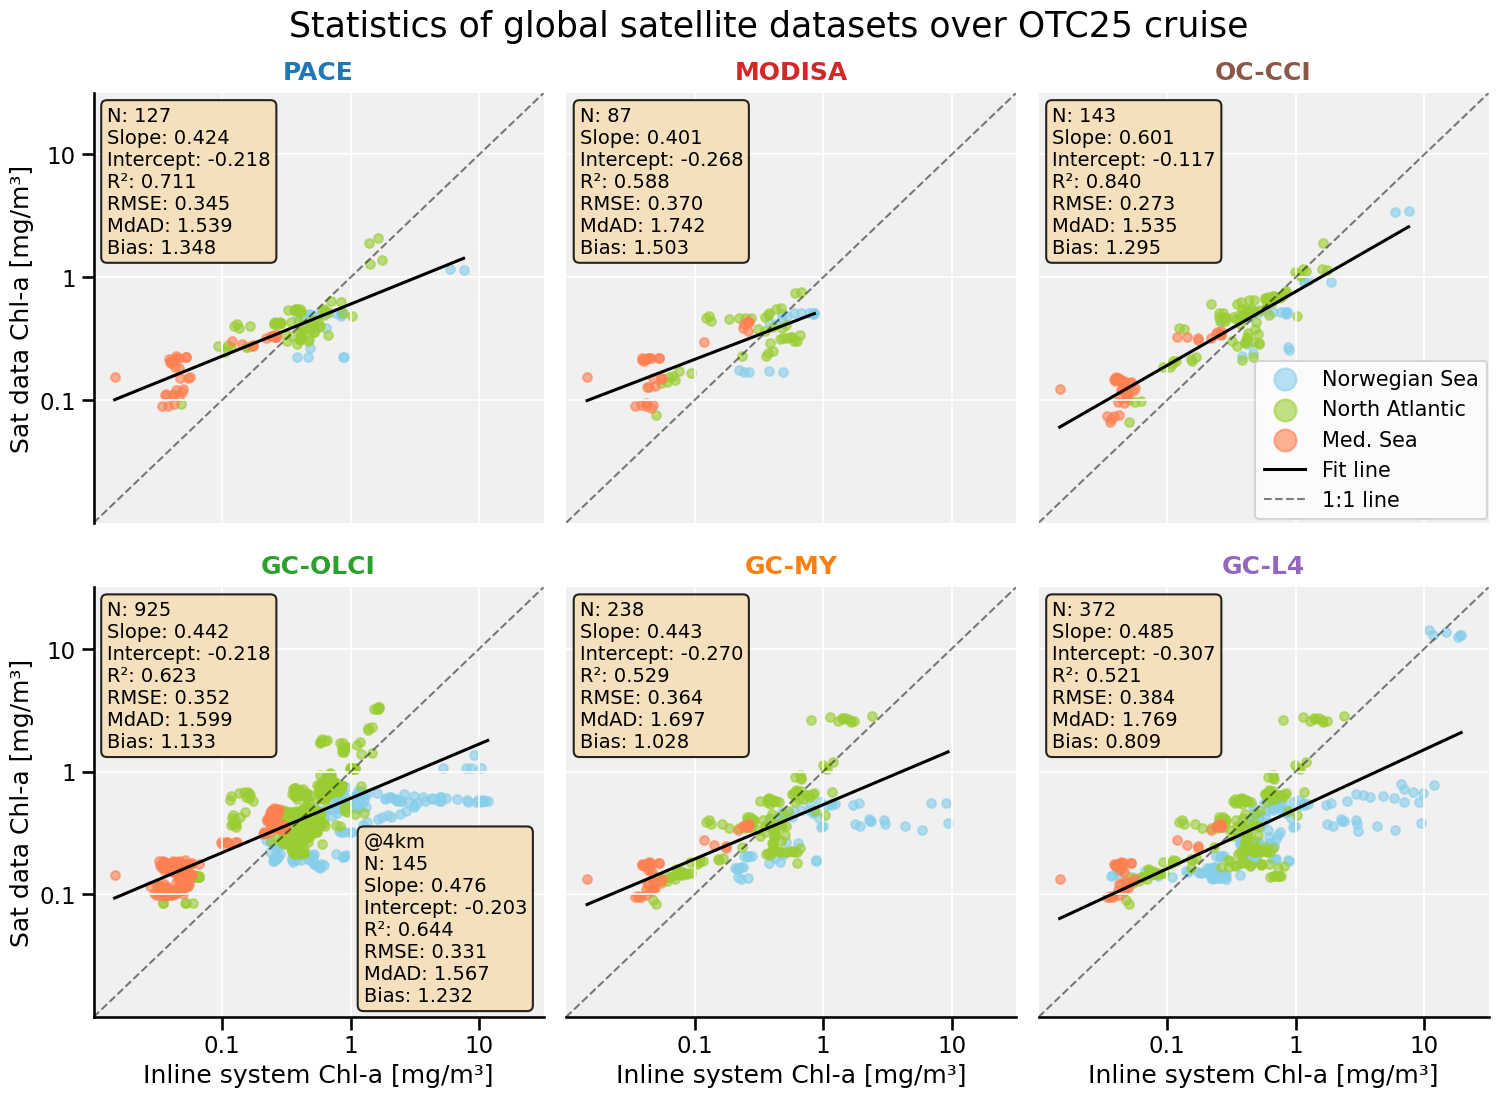

In [18]:
colors = {
    "PACE":   "#1f77b4",
    "MODISA": "#d62728",
    "OC-CCI": 'tab:brown',
    "GC-OLCI":"#2ca02c",
    "GC-MY":  "#ff7f0e",
    "GC-L4":  "tab:purple",
}

#global dataset

data_dic={
'PACE':[[ds_pace,inline_b_pace]],
'MODISA':[[ds_modisa,inline_b_modisa]],
'OC-CCI':[[ds_oc_cci,inline_oc_cci]],
"GC-OLCI":[[ds_l3olci,inline_b_olci],[ds_gc_olci_l3_interp,inline_gc_olci_l3_interp]],
"GC-MY":[[ds_l3,inline_b_l3]],    
"GC-L4":[[ds_l4,inline_b_l4]],    
}
"""
time_windows = {
    "Norwegian Sea": [("2025-04-20","2025-05-05"),"#B0E0E6"],
    "North Atlantic": [("2025-05-05","2025-05-25"),"#20B2AA"],
    "Med. Sea": [("2025-05-25","2025-06-05"),"#FA8072"]
}
"""

time_windows = {
    "Norwegian Sea": [("2025-04-20","2025-05-05"),"#87CEEB"],
    "North Atlantic": [("2025-05-05","2025-05-25"),"#9ACD32"],
    "Med. Sea": [("2025-05-25","2025-06-05"),"#FF7F50"]
}

#timefilt=True
timefilt=False
#set timefilt to false (because we already filter in time at the very beginning of the notebook, this should also help in avoiding inaccurate 
#average timestamps

time_window=["2025-04-20","2025-06-05"]

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15*1.2, 10*1.2), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05, hspace=0.15)

# style knobs
pt_color   = "#1f77b4"    # datapoints (blue)
fit_color  = 'black' #"#7f7f7f"    # fit line (grey)
oneone_kw  = dict(color="black", ls="--", lw=1.5, alpha=0.5)
lw_fit     = 2.2
#s_pts      = 14
s_pts      = 40
alpha_pts  = 0.6

# axis limits & ticks in log10 space
xylims = (-2, 1.5)
tick_pos = [-1, 0, 1]
tick_lab = ['0.1', '1', '10']  # labels shown for log10 ticks

stats_dict={}

# column titles (dataset names, color matched)
for i, (k,v) in enumerate(data_dic.items()):
    ax=axes.flatten()[i]
    
    for ii,(sat_ds,ini_ser) in enumerate(v):
        mask_cv=sat_ds['filt_cv']<0.15        
        sat = sat_ds['filt_m'][mask_cv]
        ini = ini_ser.isel(time=mask_cv.values)

        if timefilt:
            tmask = (ini['time'].dt.hour >= 10) & (ini['time'].dt.hour <= 14)
            sat = sat.isel(time=tmask.values)
            ini = ini.isel(time=tmask.values)

        # --- build log10 pairs: y = SAT, x = INLINE
        x_log, y_log = paired_log10(ini.values,sat.values)
        # regression & metrics
        st = regression_and_metrics(x_log, y_log)
        # scatter

        if ii==1:
            stats_dict[k+'*']=st
        else:
            stats_dict[k]=st

        for kk,(t,c) in time_windows.items():
            tmask2=((ini['time']>=pd.to_datetime(t[0])) &  (ini['time']<pd.to_datetime(t[1]))).values
            s1=sat.isel(time=tmask2)
            i1=ini.isel(time=tmask2)
            
            x_log1, y_log1 = paired_log10(i1.values,s1.values)
            if ii==1:
                pass
                #skip at only display statistics?
                #ax.scatter(x_log1, y_log1, s=s_pts, alpha=alpha_pts,marker='d',color=c,facecolor='white')
            else:
                ax.scatter(x_log1, y_log1, s=s_pts, alpha=alpha_pts, label=kk,color=c)
        
        #ax.scatter(x_log, y_log, s=s_pts, alpha=alpha_pts, label='Datapoints')
        
        # Fit line limited to actual scatter data range
        if np.isfinite(st['slope']):
            # get the finite range of observed x values
            xline = np.linspace(np.nanmin(x_log), np.nanmax(x_log), 100)
            yline = st['slope'] * xline + st['intercept']
            if ii==0:
                ax.plot(xline, yline, lw=lw_fit, color=fit_color, label='Fit line')

            if ii==1:
                stats_box(ax, st,xpos=0.6,ypos=0.43,extra='@4km') # resolution
            else:
                stats_box(ax, st)

    ax.plot(xylims, xylims, **oneone_kw, label='1:1 line')
    ax.set_xlim(xylims)
    ax.set_ylim(xylims)
    ax.xaxis.set_major_locator(FixedLocator(tick_pos))
    ax.yaxis.set_major_locator(FixedLocator(tick_pos))
    ax.xaxis.set_major_formatter(FixedFormatter(tick_lab))
    ax.yaxis.set_major_formatter(FixedFormatter(tick_lab))
    ax.set_title(k, color=colors[k], fontweight='bold', fontsize=18, pad=10)
    ax.set_facecolor("#F0F0F0")
    ax.grid(True, color="white", linewidth=1.2)

    for side in ('top','right'):
        ax.spines[side].set_visible(False)
    if i %3!= 0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y',length=0)
        ax.set_ylabel('', fontsize=11)
    else:
        ax.set_ylabel('Sat data Chl-a [mg/m³]')
    
    if i < 3:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='x',length=0)
        ax.set_xlabel('', fontsize=11)
    else:
        ax.set_xlabel('Inline system Chl-a [mg/m³]')

    if i == 2:
        #ax.legend(title=None, fontsize=13, loc='upper right',bbox_to_anchor=(1.68,1),markerscale=2.5)
        ax.legend(title=None, fontsize=15, loc='lower right',markerscale=2.5,bbox_to_anchor=(1.02,-0.015))
fig.suptitle('Statistics of global satellite datasets over OTC25 cruise',y=0.95,fontsize=25) #(12$\pm$2h matchup)') #\n 12$\pm$2h matchup 
#fig.savefig('stats_global.png',dpi=300,bbox_inches='tight')

# Plot for POSTTER

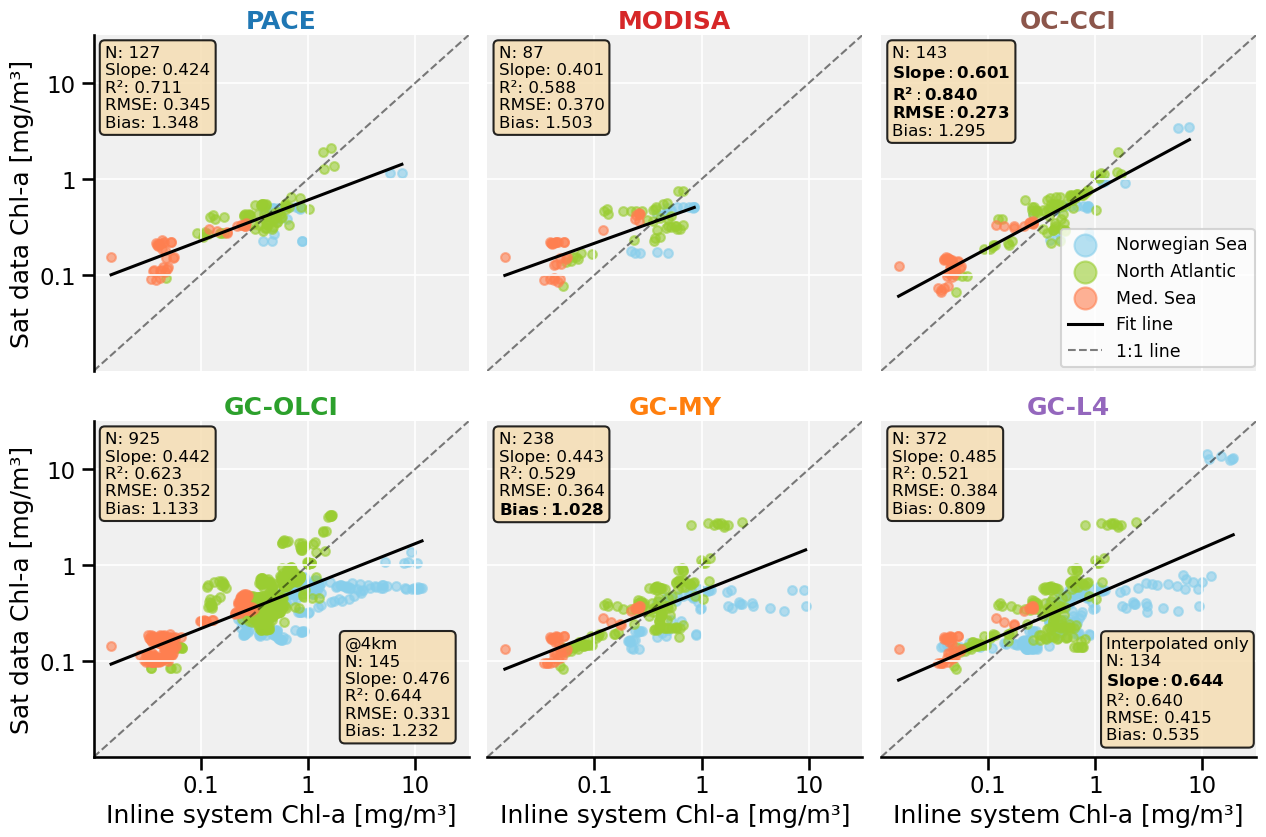

In [18]:
#additionally: In L4, add a no-data when actually no data point available
#use a (loose) criterium where we only add a flag when sat_vals would have been np.nan

ds_l4['interpolated']=xr.where(np.isnan(ds_l3['sat_vals']),1,0)

def valid_pos(a):
    """Return finite, positive values from array-like (for log10)."""
    a = np.asarray(a)
    return a[np.isfinite(a) & (a > 0)]

def paired_log10(x_sat, y_inline):
    #note: I have reversed the order in the plotting code (x-axis: inline system, y-axis: satellite data)
    """Return matched, finite log10 pairs (x_log, y_log)."""
    x = valid_pos(x_sat)
    y = valid_pos(y_inline)
    # assume arrays are already matched by index/time; align by mask of finite>0 on both
    m = np.isfinite(x_sat) & (x_sat > 0) & np.isfinite(y_inline) & (y_inline > 0)
    x = np.log10(np.asarray(x_sat)[m])
    y = np.log10(np.asarray(y_inline)[m])
    return x, y

def regression_and_metrics(x_log, y_log):
    """OLS in log space + custom metrics (also in log space)."""
    if len(x_log) < 2:
        return dict(n=len(x_log), slope=np.nan, intercept=np.nan, r2=np.nan,
                    p=np.nan, stderr=np.nan, rmse=np.nan, mdad=np.nan, bias=np.nan)
    slope, intercept, r, p, stderr = stats.linregress(x_log,y_log)
    diff = y_log - x_log
    rmse = float(np.sqrt(np.mean(diff**2)))
    mdad = float(10 ** (np.median(np.abs(diff))))
    bias = float(10 ** (np.mean(diff)))
    return dict(n=len(x_log), slope=slope, intercept=intercept, r2=r**2,
                p=p, stderr=stderr, rmse=rmse, mdad=mdad, bias=bias)

def stats_box(ax, stats_dict,xpos=0.03,ypos=0.97,extra=None,fontsize=14):
    if extra is not None:
        txt = (
            f"{extra}\n"
            f"N: {stats_dict['n']}\n"
            f"Slope: {stats_dict['slope']:.3f}\n"
            #f"Intercept: {stats_dict['intercept']:.3f}\n"
            f"R²: {stats_dict['r2']:.3f}\n"
            #f"p-value: {stats_dict['p']:.2f}\n"
            f"RMSE: {stats_dict['rmse']:.3f}\n"
            #f"MdAD: {stats_dict['mdad']:.3f}\n"
            f"Bias: {stats_dict['bias']:.3f}"
        )
    else:
        txt = (
            f"N: {stats_dict['n']}\n"
            f"Slope: {stats_dict['slope']:.3f}\n"
            #f"Intercept: {stats_dict['intercept']:.3f}\n"
            f"R²: {stats_dict['r2']:.3f}\n"
            #f"p-value: {stats_dict['p']:.2f}\n"
            f"RMSE: {stats_dict['rmse']:.3f}\n"
            #f"MdAD: {stats_dict['mdad']:.3f}\n"
            f"Bias: {stats_dict['bias']:.3f}"
        )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.85)
    ax.text(xpos, ypos, txt, transform=ax.transAxes, va='top', ha='left',
            fontsize=fontsize, bbox=props)

def stats_box_poster2(ax, stats_dict, xpos=0.03, ypos=0.97, extra=None,
              fontsize=14, highlights=None):
    """
    Draw stats box. `highlights` is an iterable of metric names to bold:
      {'slope', 'r2', 'rmse', 'bias'}.

    If N==0 or metric is NaN/inf -> 'no-data'.
    """
    def fmt(label, key):
        v = stats_dict.get(key, np.nan)
        n = stats_dict.get('n', 0)
        if n < 1 or not np.isfinite(v):
            return f"{label}: no-data"
        val_str = f"{v:.3f}"
        if highlights and key in highlights:
            # bold the number via mathtext
            #return f"{label}: $\\mathbf{{{val_str}}}$"
            return f"$\\mathbf{{{label}}}: \\mathbf{{{val_str}}}$"
        else:
            return f"{label}: {val_str}"

    lines = []
    if extra is not None:
        lines.append(extra)
    lines.append(f"N: {stats_dict.get('n', 0)}")
    lines.append(fmt("Slope", "slope"))
    lines.append(fmt("R²",    "r2"))
    lines.append(fmt("RMSE",  "rmse"))
    lines.append(fmt("Bias",  "bias"))

    txt = "\n".join(lines)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.85)
    ax.text(xpos, ypos, txt, transform=ax.transAxes, va='top', ha='left',
            fontsize=fontsize, bbox=props)


colors = {
    "PACE":   "#1f77b4",
    "MODISA": "#d62728",
    "OC-CCI": 'tab:brown',
    "GC-OLCI":"#2ca02c",
    "GC-MY":  "#ff7f0e",
    "GC-L4":  "tab:purple",
}

#global dataset

data_dic={
'PACE':[[ds_pace,inline_b_pace]],
'MODISA':[[ds_modisa,inline_b_modisa]],
'OC-CCI':[[ds_oc_cci,inline_oc_cci]],
"GC-OLCI":[[ds_l3olci,inline_b_olci],[ds_gc_olci_l3_interp,inline_gc_olci_l3_interp]],
"GC-MY":[[ds_l3,inline_b_l3]],    
"GC-L4":[[ds_l4,inline_b_l4],[ds_l4,inline_b_l4]],    #dummy repetition
}
"""
time_windows = {
    "Norwegian Sea": [("2025-04-20","2025-05-05"),"#B0E0E6"],
    "North Atlantic": [("2025-05-05","2025-05-25"),"#20B2AA"],
    "Med. Sea": [("2025-05-25","2025-06-05"),"#FA8072"]
}
"""

time_windows = {
    "Norwegian Sea": [("2025-04-20","2025-05-05"),"#87CEEB"],
    "North Atlantic": [("2025-05-05","2025-05-25"),"#9ACD32"],
    "Med. Sea": [("2025-05-25","2025-06-05"),"#FF7F50"]
}

#timefilt=True
timefilt=False
#set timefilt to false (because we already filter in time at the very beginning of the notebook, this should also help in avoiding inaccurate 
#average timestamps

time_window=["2025-04-20","2025-06-05"]

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15/40*25), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05, hspace=0.15)

# style knobs
pt_color   = "#1f77b4"    # datapoints (blue)
fit_color  = 'black' #"#7f7f7f"    # fit line (grey)
oneone_kw  = dict(color="black", ls="--", lw=1.5, alpha=0.5)
lw_fit     = 2.2
#s_pts      = 14
s_pts      = 40
alpha_pts  = 0.6

# axis limits & ticks in log10 space
xylims = (-2, 1.5)
tick_pos = [-1, 0, 1]
tick_lab = ['0.1', '1', '10']  # labels shown for log10 ticks

stats_dict={}

# manual choice of which metrics to highlight in each stats box
# keys must match how you store stats_dict: 'PACE', 'MODISA', ..., 'GC-L4', 'GC-L4*'
highlight_map = {
    'PACE':   set(),          # example
    'MODISA': set(),
    'OC-CCI': {'slope', 'r2', 'rmse'},
    'GC-OLCI': set(),                   # nothing bold
    'GC-MY':  {'bias'},
    'GC-L4':  set(),                   # main L4
    'GC-L4*': {'slope'},          # interpolated-only L4
}


# column titles (dataset names, color matched)
for i, (k,v) in enumerate(data_dic.items()):
    ax=axes.flatten()[i]
    
    for ii,(sat_ds,ini_ser) in enumerate(v):
        #hard coded extra to plot the stats for the interpolated data points
        if ii==1 and k=="GC-L4":
           dupdup=sat_ds["interpolated"]
           sat_ds=sat_ds.where(dupdup,drop=True)
           ini_ser=ini_ser[dupdup.values==1] #not sure why I have to do it this way here to work...
        
        mask_cv=sat_ds['filt_cv']<0.15        
        sat = sat_ds['filt_m'][mask_cv]
        ini = ini_ser.isel(time=mask_cv.values)

        if timefilt:
            tmask = (ini['time'].dt.hour >= 10) & (ini['time'].dt.hour <= 14)
            sat = sat.isel(time=tmask.values)
            ini = ini.isel(time=tmask.values)

        # --- build log10 pairs: y = SAT, x = INLINE
        x_log, y_log = paired_log10(ini.values,sat.values)
        # regression & metrics
        st = regression_and_metrics(x_log, y_log)
        # scatter

        if ii==1:
            stats_dict[k+'*']=st
        else:
            stats_dict[k]=st

        for kk,(t,c) in time_windows.items():
            tmask2=((ini['time']>=pd.to_datetime(t[0])) &  (ini['time']<pd.to_datetime(t[1]))).values
            s1=sat.isel(time=tmask2)
            i1=ini.isel(time=tmask2)
            
            x_log1, y_log1 = paired_log10(i1.values,s1.values)
            if ii==1:
                pass
                #skip at only display statistics?
                #ax.scatter(x_log1, y_log1, s=s_pts, alpha=alpha_pts,marker='d',color=c,facecolor='white')
            else:
                ax.scatter(x_log1, y_log1, s=s_pts, alpha=alpha_pts, label=kk,color=c)
        
        #ax.scatter(x_log, y_log, s=s_pts, alpha=alpha_pts, label='Datapoints')
        
        # Fit line limited to actual scatter data range
        if np.isfinite(st['slope']):
            # get the finite range of observed x values
            xline = np.linspace(np.nanmin(x_log), np.nanmax(x_log), 100)
            yline = st['slope'] * xline + st['intercept']
            if ii==0:
                ax.plot(xline, yline, lw=lw_fit, color=fit_color, label='Fit line')

            if ii==1 and k=="GC-L4":
                stats_box_poster2(ax, st,xpos=0.6,ypos=0.36,extra='Interpolated only',fontsize=12,highlights=("slope")) # resolution
            elif ii==1:
                stats_box_poster2(ax, st,xpos=0.67,ypos=0.36,extra='@4km',fontsize=12,highlights=highlight_map[k]) # resolution
            else:
                stats_box_poster2(ax, st,fontsize=12,highlights=highlight_map[k])

    ax.plot(xylims, xylims, **oneone_kw, label='1:1 line')
    ax.set_xlim(xylims)
    ax.set_ylim(xylims)
    ax.xaxis.set_major_locator(FixedLocator(tick_pos))
    ax.yaxis.set_major_locator(FixedLocator(tick_pos))
    ax.xaxis.set_major_formatter(FixedFormatter(tick_lab))
    ax.yaxis.set_major_formatter(FixedFormatter(tick_lab))
    ax.set_title(k, color=colors[k], fontweight='bold', fontsize=18, pad=5)
    ax.set_facecolor("#F0F0F0")
    ax.grid(True, color="white", linewidth=1.2)

    for side in ('top','right'):
        ax.spines[side].set_visible(False)
    if i %3!= 0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y',length=0)
        ax.set_ylabel('', fontsize=11)
    else:
        ax.set_ylabel('Sat data Chl-a [mg/m³]')
    
    if i < 3:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='x',length=0)
        ax.set_xlabel('', fontsize=11)
    else:
        ax.set_xlabel('Inline system Chl-a [mg/m³]')

    if i == 2:
        #ax.legend(title=None, fontsize=13, loc='upper right',bbox_to_anchor=(1.68,1),markerscale=2.5)
        ax.legend(title=None, fontsize=12.5, loc='lower right',markerscale=2.5,bbox_to_anchor=(1.02,-0.015))
#fig.suptitle('Statistics of global satellite datasets over OTC25 cruise',y=0.95,fontsize=25) #(12$\pm$2h matchup)') #\n 12$\pm$2h matchup 
fig.savefig('stats_global_poster.png',dpi=600,bbox_inches='tight')

In [258]:
# Define which metrics are better when higher vs lower
higher_is_better = ['r2']
lower_is_better = ['stderr', 'rmse', 'mdad', 'bias']
closest_to_one = ['slope']
closest_to_zero = ['intercept']
skip_highlight = ['p', 'n']

def highlight_best_worst(row):
    styles = [''] * len(row)
    
    if row.name in skip_highlight:
        return styles
    
    if row.name in higher_is_better:
        max_idx = row.argmax()
        min_idx = row.argmin()
        styles[max_idx] = 'background-color: lightgreen'
        styles[min_idx] = 'background-color: lightcoral'
    
    elif row.name in lower_is_better:
        min_idx = row.argmin()
        max_idx = row.argmax()
        styles[min_idx] = 'background-color: lightgreen'
        styles[max_idx] = 'background-color: lightcoral'
    
    elif row.name in closest_to_one:
        # Find closest to 1
        distances = np.abs(row - 1)
        best_idx = distances.argmin()
        worst_idx = distances.argmax()
        styles[best_idx] = 'background-color: lightgreen'
        styles[worst_idx] = 'background-color: lightcoral'
    
    elif row.name in closest_to_zero:
        # Find closest to 0
        distances = np.abs(row - 0)
        best_idx = distances.argmin()
        worst_idx = distances.argmax()
        styles[best_idx] = 'background-color: lightgreen'
        styles[worst_idx] = 'background-color: lightcoral'
    
    return styles

In [259]:
pd.DataFrame(stats_dict).style.apply(highlight_best_worst,axis=1).format(precision=3)

,PACE,MODISA,OC-CCI,GC-OLCI,GC-OLCI*,GC-MY,GC-L4
n,127.000,87.000,143.000,925.000,145.000,238.000,372.000
slope,0.424,0.401,0.601,0.442,0.476,0.443,0.485
intercept,-0.218,-0.268,-0.117,-0.218,-0.203,-0.270,-0.307
r2,0.711,0.588,0.840,0.623,0.644,0.529,0.521
p,0.000,0.000,0.000,0.000,0.000,0.000,0.000
stderr,0.024,0.036,0.022,0.011,0.030,0.027,0.024
rmse,0.345,0.370,0.273,0.352,0.331,0.364,0.384
mdad,1.539,1.742,1.535,1.599,1.567,1.697,1.769
bias,1.348,1.503,1.295,1.133,1.232,1.028,0.809


In [260]:
stats_dict

{'PACE': {'n': 127,
  'slope': np.float64(0.4242524967679073),
  'intercept': np.float64(-0.21823577619112444),
  'r2': np.float64(0.7105233025166449),
  'p': np.float64(1.8892763471762273e-35),
  'stderr': np.float64(0.02422071961169442),
  'rmse': 0.34506015130192025,
  'mdad': 1.538931845015448,
  'bias': 1.3478119887989515},
 'MODISA': {'n': 87,
  'slope': np.float64(0.40083393133627737),
  'intercept': np.float64(-0.2679865782635348),
  'r2': np.float64(0.5876431425556228),
  'p': np.float64(4.978193107579133e-18),
  'stderr': np.float64(0.03641956797727226),
  'rmse': 0.37013462693876337,
  'mdad': 1.7423969781540758,
  'bias': 1.5028094393862559},
 'OC-CCI': {'n': 143,
  'slope': np.float64(0.6011917977714467),
  'intercept': np.float64(-0.11676028694588958),
  'r2': np.float64(0.8395480183754406),
  'p': np.float64(6.930868900097902e-58),
  'stderr': np.float64(0.02213366143599902),
  'rmse': 0.27277674345758346,
  'mdad': 1.5349166220269874,
  'bias': 1.2950088855745272},
 'GC

In [262]:
df=pd.DataFrame(stats_dict)

def print_latex(df):

    # Metrics to include (exclude 'p' and 'stderr')
    metrics_to_show = ['n', 'slope', 'intercept', 'r2', 'rmse', 'mdad', 'bias']
    
    # Function to find best and worst values
    def get_highlights(row_name, values):
        if row_name in skip_highlight:
            return None, None
        
        if row_name in higher_is_better:
            best_idx = values.idxmax()
            worst_idx = values.idxmin()
        elif row_name in lower_is_better:
            best_idx = values.idxmin()
            worst_idx = values.idxmax()
        elif row_name in closest_to_one:
            abs_diff = (values - 1).abs()
            best_idx = abs_diff.idxmin()
            worst_idx = abs_diff.idxmax()
        elif row_name in closest_to_zero:
            abs_diff = values.abs()
            best_idx = abs_diff.idxmin()
            worst_idx = abs_diff.idxmax()
        else:
            return None, None
        
        return best_idx, worst_idx
    
    
    # Generate LaTeX table
    latex_lines = []
    latex_lines.append("\\begin{table}[htbp]")
    latex_lines.append("\\centering")
    latex_lines.append("\\caption{Statistical comparison across datasets}")
    latex_lines.append("\\label{tab:dataset_comparison}")
    
    # Table structure
    n_cols = len(df.columns)
    latex_lines.append(f"\\begin{{tabular}}{{l{'r' * n_cols}}}")
    latex_lines.append("\\hline")
    
    # Header row
    header = "Metric & " + " & ".join(df.columns) + " \\\\"
    latex_lines.append(header)
    latex_lines.append("\\hline")
    
    # Data rows
    for metric in metrics_to_show:
        row_values = df.loc[metric]
        best_idx, worst_idx = get_highlights(metric, row_values)
        
        # Format metric name
        metric_display = metric.replace('_', '\\_')
        if metric == 'r2':
            metric_display = 'R$^2$'
        elif metric == 'rmse':
            metric_display = 'RMSE'
        elif metric == 'mdad':
            metric_display = 'MdAD'
        elif metric == 'bias':
            metric_display = 'Bias'
        elif metric == 'stderr':
            metric_display = 'Std. Error'
        elif metric == 'n':
            metric_display = 'n'
        elif metric == 'slope':
            metric_display = 'Slope'
        elif metric == 'intercept':
            metric_display = 'Intercept'
        
        row_str = metric_display + " & "
        
        # Format each value
        formatted_values = []
        for col in df.columns:
            value = row_values[col]
            
            # Format number based on metric
            if metric == 'n':
                formatted = f"{int(value)}"
            elif metric in ['r2']:
                formatted = f"{value:.3f}"
            else:
                formatted = f"{value:.3f}"
            
            # Apply highlighting
            if best_idx is not None and col == best_idx:
                formatted = f"\\textbf{{{formatted}}}"
            elif worst_idx is not None and col == worst_idx:
                formatted = f"\\textit{{{formatted}}}"
            
            formatted_values.append(formatted)
        
        row_str += " & ".join(formatted_values) + " \\\\"
        latex_lines.append(row_str)
    
    latex_lines.append("\\hline")
    latex_lines.append("\\end{tabular}")
    latex_lines.append("\\end{table}")
    
    # Print the LaTeX table
    latex_output = "\n".join(latex_lines)
    print(latex_output)
    print("\n" + "="*80 + "\n")
    print("LaTeX table generated successfully!")
    print("Best values are highlighted in bold, worst values in italics.")

In [263]:
print_latex(pd.DataFrame(stats_dict))

\begin{table}[htbp]
\centering
\caption{Statistical comparison across datasets}
\label{tab:dataset_comparison}
\begin{tabular}{lrrrrrrr}
\hline
Metric & PACE & MODISA & OC-CCI & GC-OLCI & GC-OLCI* & GC-MY & GC-L4 \\
\hline
n & 127 & 87 & 143 & 925 & 145 & 238 & 372 \\
Slope & 0.424 & \textit{0.401} & \textbf{0.601} & 0.442 & 0.476 & 0.443 & 0.485 \\
Intercept & -0.218 & -0.268 & \textbf{-0.117} & -0.218 & -0.203 & -0.270 & \textit{-0.307} \\
R$^2$ & 0.711 & 0.588 & \textbf{0.840} & 0.623 & 0.644 & 0.529 & \textit{0.521} \\
RMSE & 0.345 & 0.370 & \textbf{0.273} & 0.352 & 0.331 & 0.364 & \textit{0.384} \\
MdAD & 1.539 & 1.742 & \textbf{1.535} & 1.599 & 1.567 & 1.697 & \textit{1.769} \\
Bias & 1.348 & \textit{1.503} & 1.295 & 1.133 & 1.232 & 1.028 & \textbf{0.809} \\
\hline
\end{tabular}
\end{table}


LaTeX table generated successfully!
Best values are highlighted in bold, worst values in italics.


# Norwegian Sea

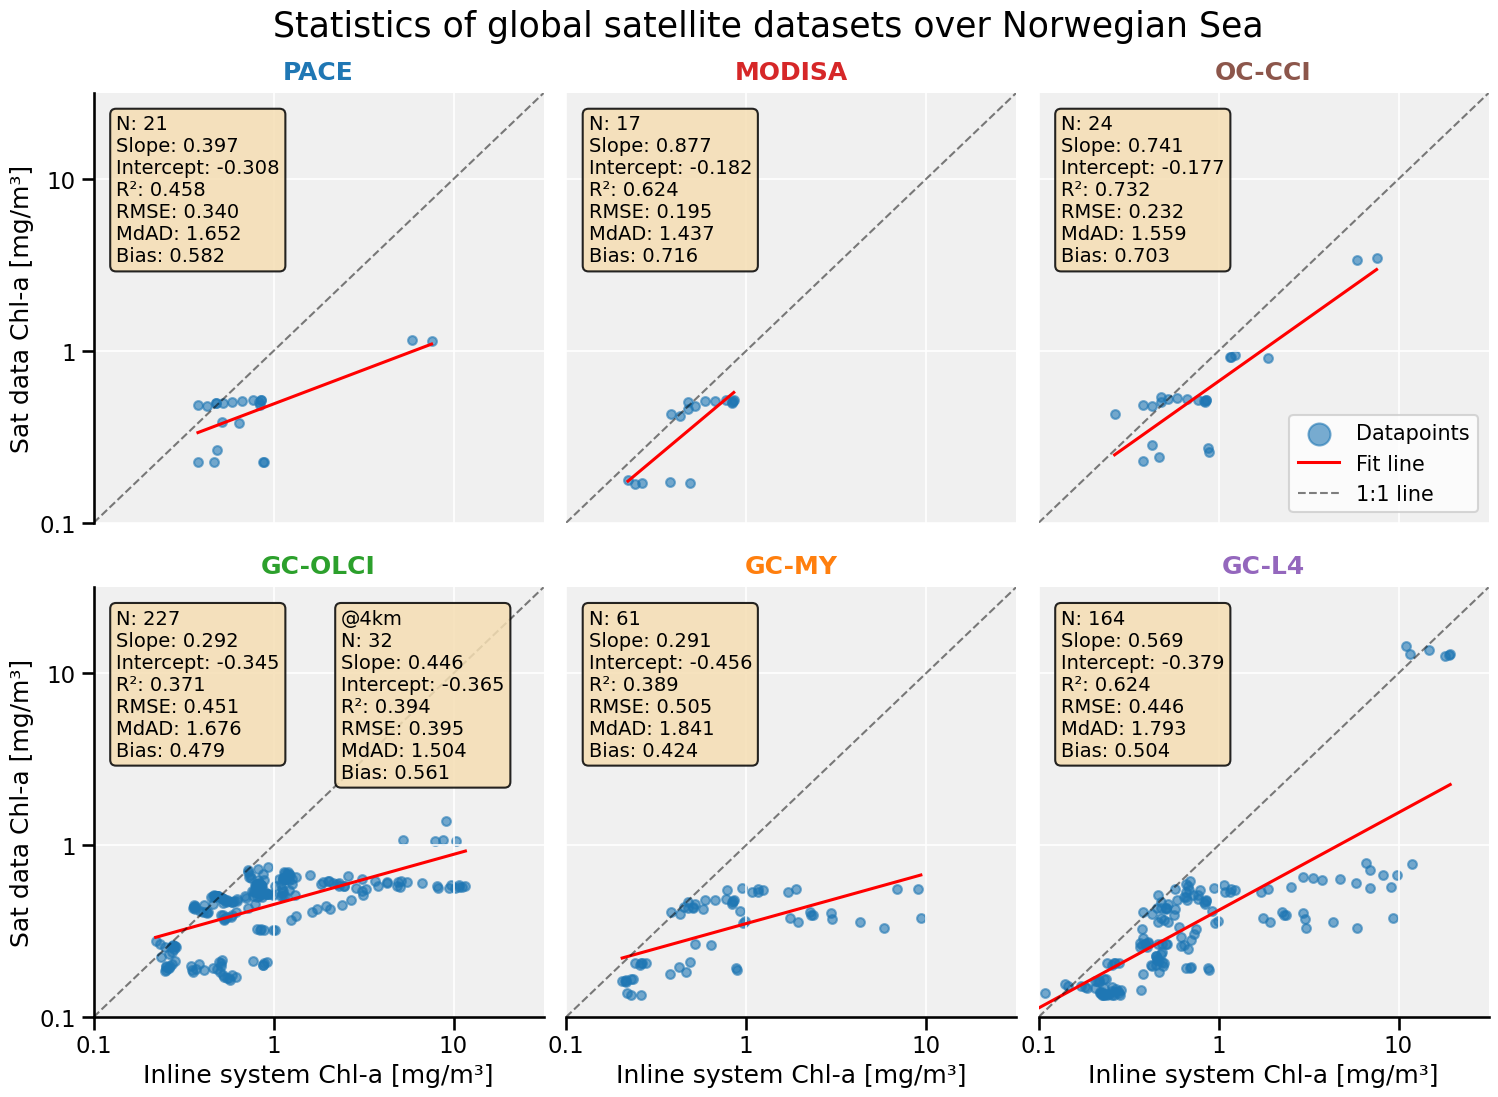

In [267]:
colors = {
    "PACE":   "#1f77b4",
    "MODISA": "#d62728",
    "OC-CCI": 'tab:brown',
    "GC-OLCI":"#2ca02c",
    "GC-MY":  "#ff7f0e",
    "GC-L4":  "tab:purple",
}

data_dic={
'PACE':[[ds_pace,inline_b_pace]],
'MODISA':[[ds_modisa,inline_b_modisa]],
'OC-CCI':[[ds_oc_cci,inline_oc_cci]],
"GC-OLCI":[[ds_l3olci,inline_b_olci],[ds_gc_olci_l3_interp,inline_gc_olci_l3_interp]],
"GC-MY":[[ds_l3,inline_b_l3]],    
"GC-L4":[[ds_l4,inline_b_l4]],    
}

time=time_windows['Norwegian Sea'][0]

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15*1.2, 10*1.2), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05, hspace=0.15)

# style knobs
pt_color   = "#1f77b4"    # datapoints (blue)
fit_color  = 'red' #"#7f7f7f"    # fit line (grey)
oneone_kw  = dict(color="black", ls="--", lw=1.5, alpha=0.5)
lw_fit     = 2.2
s_pts      = 40
alpha_pts  = 0.6

# axis limits & ticks in log10 space
xylims = (-1, 1.5)
tick_pos = [-1, 0, 1]
tick_lab = ['0.1', '1', '10']  # labels shown for log10 ticks

stats_dict={}

# column titles (dataset names, color matched)
for i, (k,v) in enumerate(data_dic.items()):
    ax=axes.flatten()[i]
    
    for ii,(sat_ds,ini_ser) in enumerate(v):


        mask0=(ini_ser['time']>=pd.to_datetime(time[0])) & (ini_ser['time']<pd.to_datetime(time[1]))

        ini_ser=ini_ser.isel(time=mask0.values)
        sat_ds=sat_ds.isel(time=mask0.values)
        
        mask_cv=sat_ds['filt_cv']<0.15
        
        sat = sat_ds['filt_m'][mask_cv]
        ini = ini_ser.isel(time=mask_cv.values)

        # time selection
        #mtime = (ini['time'] >= t0) & (ini['time'] < t1)
        #sat = sat[mtime]
        #ini = ini[mtime]
                # optional daytime filter
        if timefilt:
            tmask = (ini['time'].dt.hour >= 10) & (ini['time'].dt.hour <= 14)
            sat = sat.isel(time=tmask.values)
            ini = ini.isel(time=tmask.values)

        # --- build log10 pairs: y = SAT, x = INLINE
        x_log, y_log = paired_log10(ini.values,sat.values)
        # regression & metrics
        st = regression_and_metrics(x_log, y_log)
        # scatter

        
        if ii==0:
            ax.scatter(x_log, y_log, s=s_pts, alpha=alpha_pts, label='Datapoints')
        
        # Fit line limited to actual scatter data range
        if np.isfinite(st['slope']):
            # get the finite range of observed x values
            xline = np.linspace(np.nanmin(x_log), np.nanmax(x_log), 100)
            yline = st['slope'] * xline + st['intercept']
            if ii==0:
                ax.plot(xline, yline, lw=lw_fit, color=fit_color, label='Fit line')

            if ii==1:
                stats_box(ax, st,xpos=0.55,ypos=0.95,extra='@4km')
                stats_dict['GC-OLCI*']=st
            else:
#                if k=='GC-OLCI':
#                    stats_box(ax, st,xpos=0.55,ypos=0.95)
#                else:
                stats_box(ax, st,xpos=0.05,ypos=0.95)
                stats_dict[k]=st

    ax.plot(xylims, xylims, **oneone_kw, label='1:1 line')
    ax.set_xlim(xylims)
    ax.set_ylim(xylims)
    ax.xaxis.set_major_locator(FixedLocator(tick_pos))
    ax.yaxis.set_major_locator(FixedLocator(tick_pos))
    ax.xaxis.set_major_formatter(FixedFormatter(tick_lab))
    ax.yaxis.set_major_formatter(FixedFormatter(tick_lab))
    ax.set_title(k, color=colors[k], fontweight='bold', fontsize=18, pad=10)
    ax.set_facecolor("#F0F0F0")
    ax.grid(True, color="white", linewidth=1.2)

    for side in ('top','right'):
        ax.spines[side].set_visible(False)
    if i %3!= 0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y',length=0)
        ax.set_ylabel('', fontsize=11)
    else:
        ax.set_ylabel('Sat data Chl-a [mg/m³]')
    
    if i < 3:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='x',length=0)
        ax.set_xlabel('', fontsize=11)
    else:
        ax.set_xlabel('Inline system Chl-a [mg/m³]')

    if i == 2:
        ax.legend(title=None, fontsize=15, loc='lower right',markerscale=2.5)
        

fig.suptitle(r'Statistics of global satellite datasets over Norwegian Sea',fontsize=25,y=0.95) 
fig.savefig('stats_norwegian.png',dpi=300,bbox_inches='tight')

In [268]:
pd.DataFrame(stats_dict).style.apply(highlight_best_worst,axis=1).format(precision=3)

,PACE,MODISA,OC-CCI,GC-OLCI,GC-OLCI*,GC-MY,GC-L4
n,21.000,17.000,24.000,227.000,32.000,61.000,164.000
slope,0.397,0.877,0.741,0.292,0.446,0.291,0.569
intercept,-0.308,-0.182,-0.177,-0.345,-0.365,-0.456,-0.379
r2,0.458,0.624,0.732,0.371,0.394,0.389,0.624
p,0.001,0.000,0.000,0.000,0.000,0.000,0.000
stderr,0.099,0.176,0.096,0.025,0.101,0.048,0.035
rmse,0.340,0.195,0.232,0.451,0.395,0.505,0.446
mdad,1.652,1.437,1.559,1.676,1.504,1.841,1.793
bias,0.582,0.716,0.703,0.479,0.561,0.424,0.504


In [269]:
print_latex(pd.DataFrame(stats_dict))

\begin{table}[htbp]
\centering
\caption{Statistical comparison across datasets}
\label{tab:dataset_comparison}
\begin{tabular}{lrrrrrrr}
\hline
Metric & PACE & MODISA & OC-CCI & GC-OLCI & GC-OLCI* & GC-MY & GC-L4 \\
\hline
n & 21 & 17 & 24 & 227 & 32 & 61 & 164 \\
Slope & 0.397 & \textbf{0.877} & 0.741 & 0.292 & 0.446 & \textit{0.291} & 0.569 \\
Intercept & -0.308 & -0.182 & \textbf{-0.177} & -0.345 & -0.365 & \textit{-0.456} & -0.379 \\
R$^2$ & 0.458 & 0.624 & \textbf{0.732} & \textit{0.371} & 0.394 & 0.389 & 0.624 \\
RMSE & 0.340 & \textbf{0.195} & 0.232 & 0.451 & 0.395 & \textit{0.505} & 0.446 \\
MdAD & 1.652 & \textbf{1.437} & 1.559 & 1.676 & 1.504 & \textit{1.841} & 1.793 \\
Bias & 0.582 & \textit{0.716} & 0.703 & 0.479 & 0.561 & \textbf{0.424} & 0.504 \\
\hline
\end{tabular}
\end{table}


LaTeX table generated successfully!
Best values are highlighted in bold, worst values in italics.


# North Atlantic

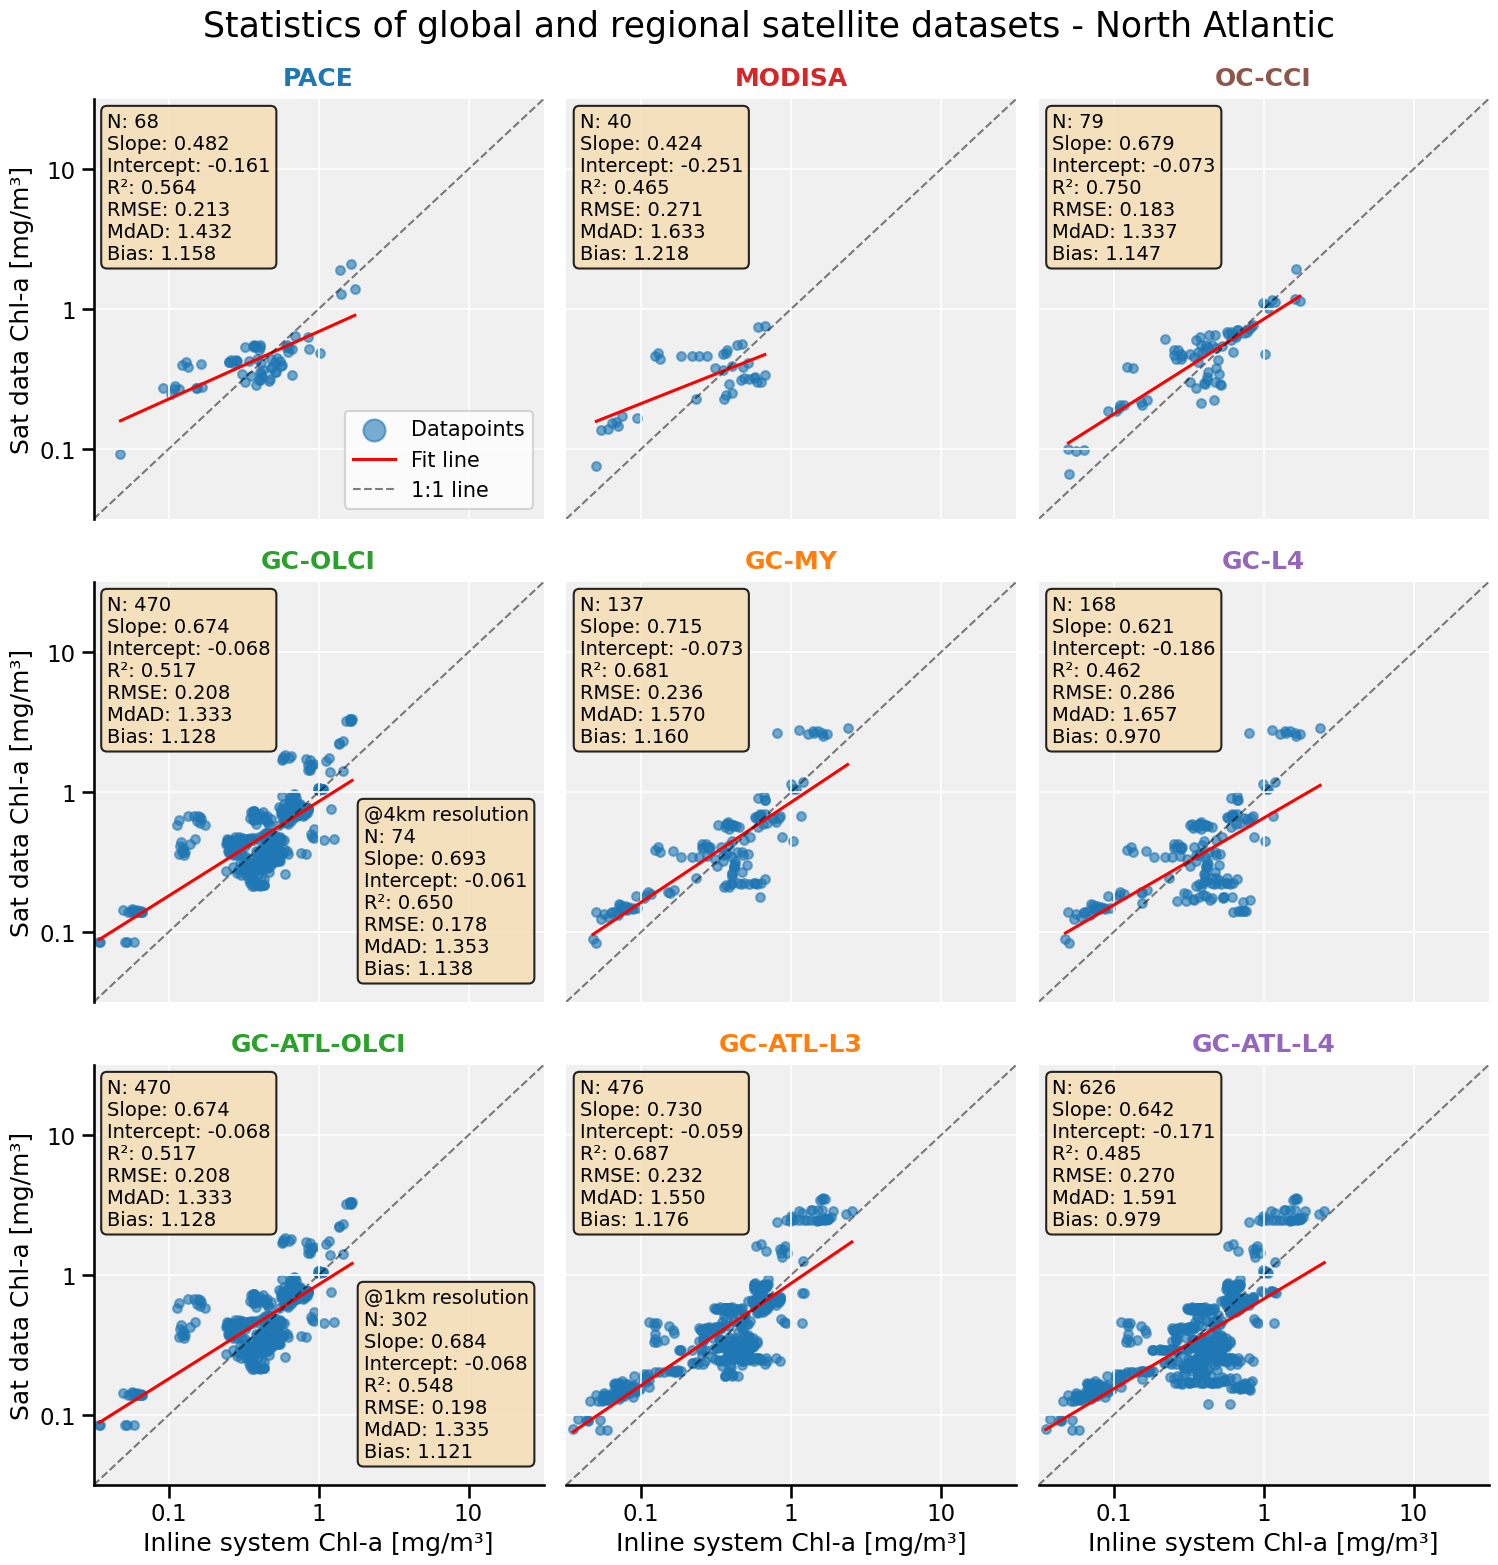

In [270]:
colors = {
    "PACE":   "#1f77b4",
    "MODISA": "#d62728",
    "OC-CCI": 'tab:brown',
    "GC-OLCI":"#2ca02c",
    "GC-MY":  "#ff7f0e",
    "GC-L4":  "tab:purple",
    "GC-ATL-L3":"#ff7f0e",
    "GC-ATL-L4":"tab:purple",
    "GC-ATL-OLCI":"#2ca02c",
}

data_dic={
'PACE':[[ds_pace,inline_b_pace]],
'MODISA':[[ds_modisa,inline_b_modisa]],
'OC-CCI':[[ds_oc_cci,inline_oc_cci]],
"GC-OLCI":[[ds_l3olci,inline_b_olci],[ds_gc_olci_l3_interp,inline_gc_olci_l3_interp]],
"GC-MY":[[ds_l3,inline_b_l3]],    
"GC-L4":[[ds_l4,inline_b_l4]],
"GC-ATL-OLCI":[[ds_gc_atl_olci,inline_gc_atl_olci],[ds_gc_atl_olci_l3_interp,inline_gc_atl_olci_l3_interp]],
"GC-ATL-L3":[[ds_gc_atl_l3,inline_gc_atl_l3]],
"GC-ATL-L4":[[ds_gc_atl_l4,inline_gc_atl_l4]],
}



time=time_windows['North Atlantic'][0]

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15*1.2, 15*1.2), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05, hspace=0.15)

# style knobs
pt_color   = "#1f77b4"    # datapoints (blue)
fit_color  = 'red' #"#7f7f7f"    # fit line (grey)
oneone_kw  = dict(color="black", ls="--", lw=1.5, alpha=0.5)
lw_fit     = 2.2
s_pts      = 40
alpha_pts  = 0.6

# axis limits & ticks in log10 space
xylims = (-1.5, 1.5)
tick_pos = [-1, 0, 1]
tick_lab = ['0.1', '1', '10']  # labels shown for log10 ticks

stats_dict={}

# column titles (dataset names, color matched)
for i, (k,v) in enumerate(data_dic.items()):
    ax=axes.flatten()[i]
    
    for ii,(sat_ds,ini_ser) in enumerate(v):


        mask0=(ini_ser['time']>=pd.to_datetime(time[0])) & (ini_ser['time']<pd.to_datetime(time[1]))

        ini_ser=ini_ser.isel(time=mask0.values)
        sat_ds=sat_ds.isel(time=mask0.values)
        
        mask_cv=sat_ds['filt_cv']<0.15
        
        sat = sat_ds['filt_m'][mask_cv]
        ini = ini_ser.isel(time=mask_cv.values)

        # time selection
        #mtime = (ini['time'] >= t0) & (ini['time'] < t1)
        #sat = sat[mtime]
        #ini = ini[mtime]
                # optional daytime filter
        if timefilt:
            tmask = (ini['time'].dt.hour >= 10) & (ini['time'].dt.hour <= 14)
            sat = sat.isel(time=tmask.values)
            ini = ini.isel(time=tmask.values)

        # --- build log10 pairs: x = SAT, y = INLINE
        x_log, y_log = paired_log10(ini.values,sat.values)
        # regression & metrics
        st = regression_and_metrics(x_log, y_log)
        # scatter

        if ii==0:
            ax.scatter(x_log, y_log, s=s_pts, alpha=alpha_pts, label='Datapoints')

        if (ii==1 and i==3) or (ii==1 and i==6):
            stats_dict[k+'*']=st
        else:
            stats_dict[k]=st
        
        # Fit line limited to actual scatter data range
        if np.isfinite(st['slope']):
            # get the finite range of observed x values
            xline = np.linspace(np.nanmin(x_log), np.nanmax(x_log), 100)
            yline = st['slope'] * xline + st['intercept']
            if ii==0:
                ax.plot(xline, yline, lw=lw_fit, color=fit_color, label='Fit line')

            if ii==1 and i==3:
                stats_box(ax, st,xpos=0.6,ypos=0.47,extra='@4km resolution')
            elif (ii==1 and i==6):
                stats_box(ax, st,xpos=0.6,ypos=0.47,extra='@1km resolution')
            else:
                #if k=='GC-OLCI':
                #    stats_box(ax, st,xpos=0.6,ypos=0.77)
                #else:
                stats_box(ax, st) #,xpos=0.6,ypos=0.37

    ax.plot(xylims, xylims, **oneone_kw, label='1:1 line')
    ax.set_xlim(xylims)
    ax.set_ylim(xylims)
    ax.xaxis.set_major_locator(FixedLocator(tick_pos))
    ax.yaxis.set_major_locator(FixedLocator(tick_pos))
    ax.xaxis.set_major_formatter(FixedFormatter(tick_lab))
    ax.yaxis.set_major_formatter(FixedFormatter(tick_lab))
    ax.set_title(k, color=colors[k], fontweight='bold', fontsize=18, pad=10)
    ax.set_facecolor("#F0F0F0")
    ax.grid(True, color="white", linewidth=1.2)

    for side in ('top','right'):
        ax.spines[side].set_visible(False)
    if i %3!= 0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y',length=0)
        ax.set_ylabel('', fontsize=11)
    else:
        ax.set_ylabel('Sat data Chl-a [mg/m³]')
    
    if i < 6:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='x',length=0)
        ax.set_xlabel('', fontsize=11)
    else:
        ax.set_xlabel('Inline system Chl-a [mg/m³]')

    #if i == 2:
    #    ax.legend(title=None, fontsize=15, loc='upper right',bbox_to_anchor=(1.55,1),markerscale=2.5)
    if i==0:
        ax.legend(title=None, fontsize=15, loc='lower right',markerscale=2.5)

fig.suptitle(r'Statistics of global and regional satellite datasets - North Atlantic',y=0.93,fontsize=25) 
fig.savefig('stats_na.png',dpi=300,bbox_inches='tight')

In [271]:
pd.DataFrame(stats_dict).style.apply(highlight_best_worst,axis=1).format(precision=3)

,PACE,MODISA,OC-CCI,GC-OLCI,GC-OLCI*,GC-MY,GC-L4,GC-ATL-OLCI,GC-ATL-OLCI*,GC-ATL-L3,GC-ATL-L4
n,68.000,40.000,79.000,470.000,74.000,137.000,168.000,470.000,302.000,476.000,626.000
slope,0.482,0.424,0.679,0.674,0.693,0.715,0.621,0.674,0.684,0.730,0.642
intercept,-0.161,-0.251,-0.073,-0.068,-0.061,-0.073,-0.186,-0.068,-0.068,-0.059,-0.171
r2,0.564,0.465,0.750,0.517,0.650,0.681,0.462,0.517,0.548,0.687,0.485
p,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
stderr,0.052,0.074,0.045,0.030,0.060,0.042,0.052,0.030,0.036,0.023,0.026
rmse,0.213,0.271,0.183,0.208,0.178,0.236,0.286,0.208,0.198,0.232,0.270
mdad,1.432,1.633,1.337,1.333,1.353,1.570,1.657,1.333,1.335,1.550,1.591
bias,1.158,1.218,1.147,1.128,1.138,1.160,0.970,1.128,1.121,1.176,0.979


In [272]:
stats_dict.pop('GC-ATL-OLCI')

{'n': 470,
 'slope': np.float64(0.6740918595686297),
 'intercept': np.float64(-0.06785872737936435),
 'r2': np.float64(0.5168920037323305),
 'p': np.float64(5.961762631577897e-76),
 'stderr': np.float64(0.030124396979283145),
 'rmse': 0.2082058731959938,
 'mdad': 1.3325940545353203,
 'bias': 1.1281727913488389}

In [273]:
print_latex(pd.DataFrame(stats_dict))

\begin{table}[htbp]
\centering
\caption{Statistical comparison across datasets}
\label{tab:dataset_comparison}
\begin{tabular}{lrrrrrrrrrr}
\hline
Metric & PACE & MODISA & OC-CCI & GC-OLCI & GC-OLCI* & GC-MY & GC-L4 & GC-ATL-OLCI* & GC-ATL-L3 & GC-ATL-L4 \\
\hline
n & 68 & 40 & 79 & 470 & 74 & 137 & 168 & 302 & 476 & 626 \\
Slope & 0.482 & \textit{0.424} & 0.679 & 0.674 & 0.693 & 0.715 & 0.621 & 0.684 & \textbf{0.730} & 0.642 \\
Intercept & -0.161 & \textit{-0.251} & -0.073 & -0.068 & -0.061 & -0.073 & -0.186 & -0.068 & \textbf{-0.059} & -0.171 \\
R$^2$ & 0.564 & 0.465 & \textbf{0.750} & 0.517 & 0.650 & 0.681 & \textit{0.462} & 0.548 & 0.687 & 0.485 \\
RMSE & 0.213 & 0.271 & 0.183 & 0.208 & \textbf{0.178} & 0.236 & \textit{0.286} & 0.198 & 0.232 & 0.270 \\
MdAD & 1.432 & 1.633 & 1.337 & \textbf{1.333} & 1.353 & 1.570 & \textit{1.657} & 1.335 & 1.550 & 1.591 \\
Bias & 1.158 & \textit{1.218} & 1.147 & 1.128 & 1.138 & 1.160 & \textbf{0.970} & 1.121 & 1.176 & 0.979 \\
\hline
\end{tabular}


# Mediterranean Sea

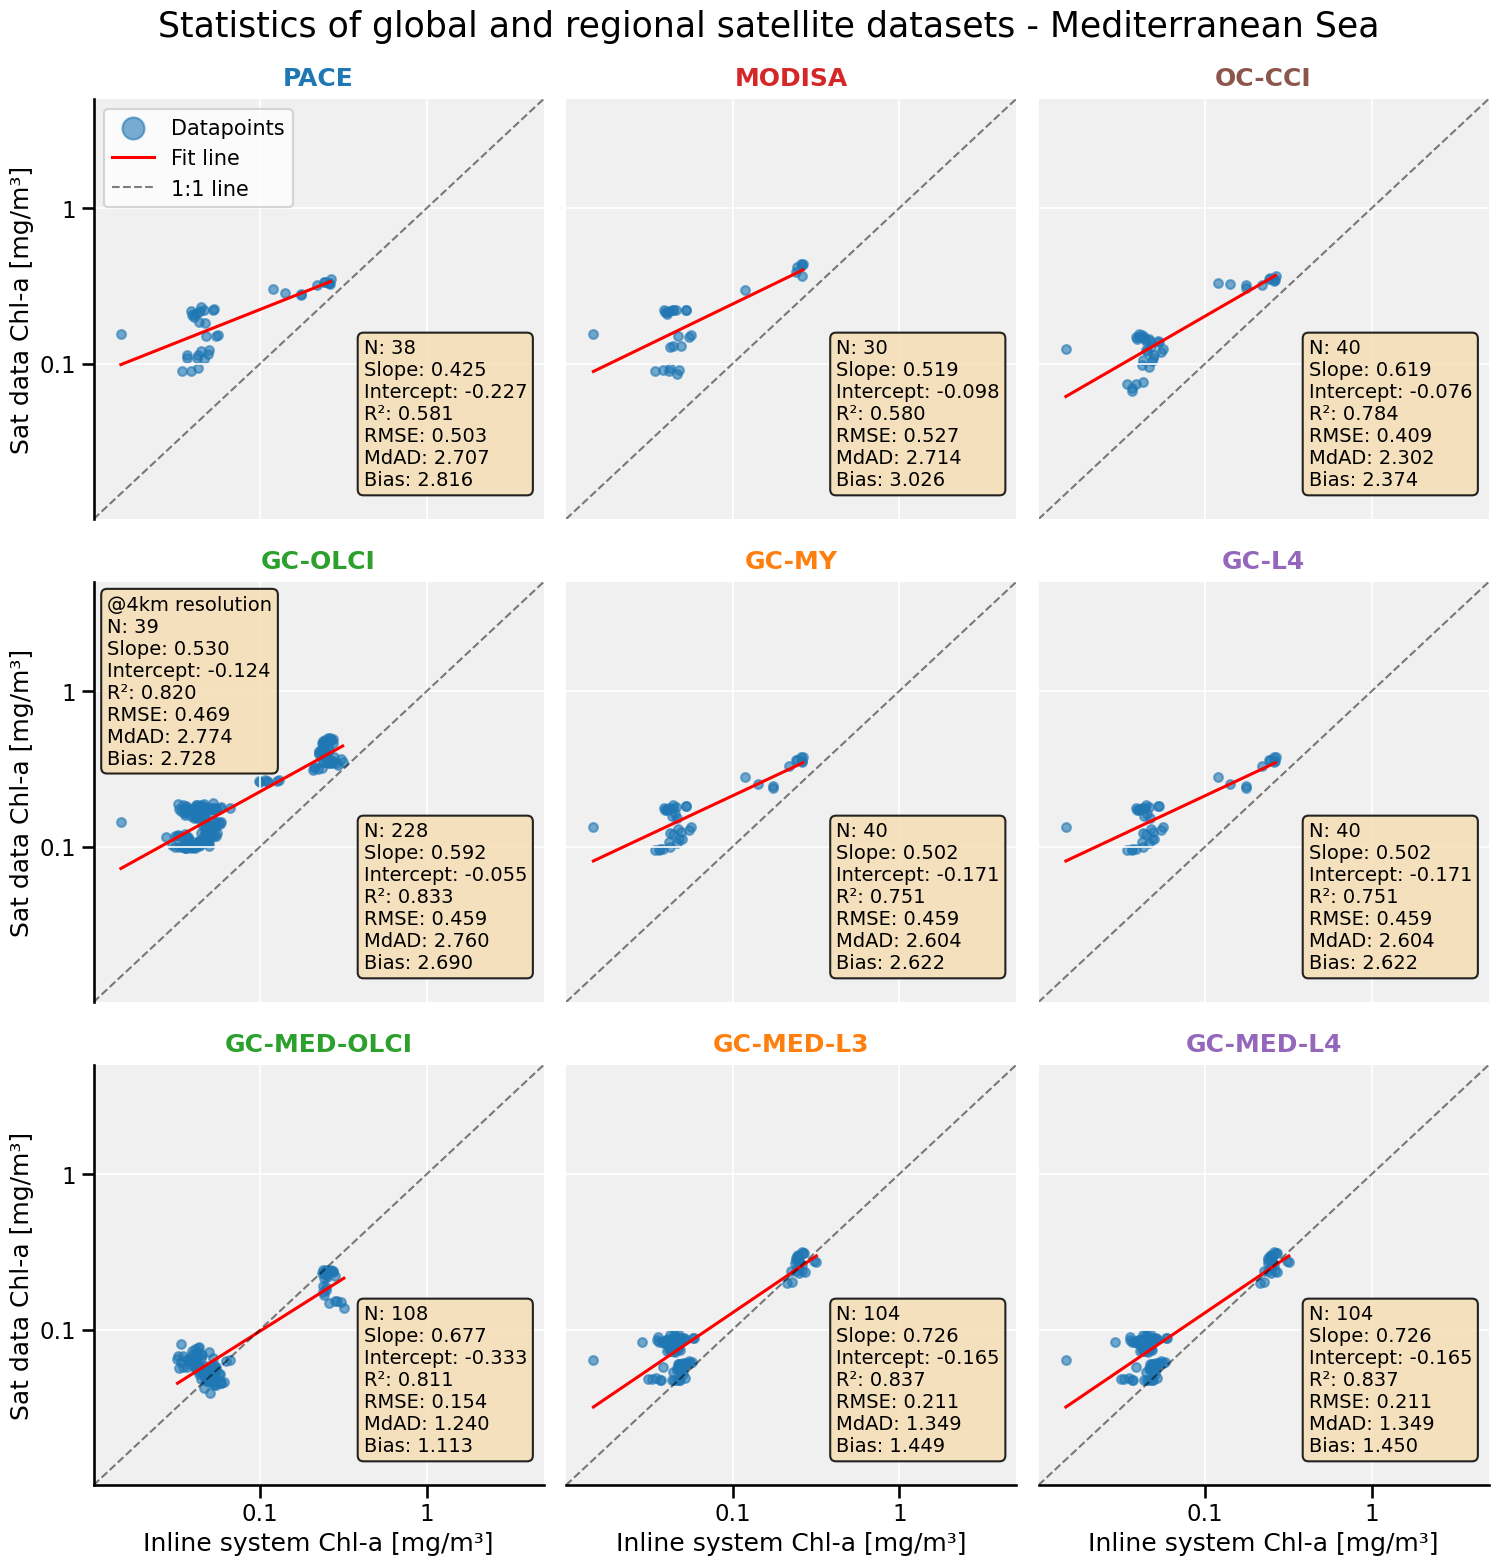

In [278]:
colors = {
    "PACE":   "#1f77b4",
    "MODISA": "#d62728",
    "OC-CCI": 'tab:brown',
    "GC-OLCI":"#2ca02c",
    "GC-MY":  "#ff7f0e",
    "GC-L4":  "tab:purple",
    "GC-MED-L3":"#ff7f0e",
    "GC-MED-L4":"tab:purple",
    "GC-MED-OLCI":"#2ca02c",
}

data_dic={
'PACE':[[ds_pace,inline_b_pace]],
'MODISA':[[ds_modisa,inline_b_modisa]],
'OC-CCI':[[ds_oc_cci,inline_oc_cci]],
"GC-OLCI":[[ds_l3olci,inline_b_olci],[ds_gc_olci_l3_interp,inline_gc_olci_l3_interp]],
"GC-MY":[[ds_l3,inline_b_l3]],    
"GC-L4":[[ds_l4,inline_b_l4]],
"GC-MED-OLCI":[[ds_gc_med_olci_l3,inline_gc_med_olci_l3]],
"GC-MED-L3":[[ds_gc_med_l3,inline_gc_med_l3]],
"GC-MED-L4":[[ds_gc_med_l4,inline_gc_med_l4]],
}

time=time_windows['Med. Sea'][0]

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15*1.2, 15*1.2), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05, hspace=0.15)

# style knobs
pt_color   = "#1f77b4"    # datapoints (blue)
fit_color  = 'red' #"#7f7f7f"    # fit line (grey)
oneone_kw  = dict(color="black", ls="--", lw=1.5, alpha=0.5)
lw_fit     = 2.2
s_pts      = 40
alpha_pts  = 0.6

# axis limits & ticks in log10 space
xylims = (-2, 0.7)
tick_pos = [-1, 0, 1]
tick_lab = ['0.1', '1', '10']  # labels shown for log10 ticks

stats_dict={}

# column titles (dataset names, color matched)
for i, (k,v) in enumerate(data_dic.items()):
    ax=axes.flatten()[i]
    
    for ii,(sat_ds,ini_ser) in enumerate(v):


        mask0=(ini_ser['time']>=pd.to_datetime(time[0])) & (ini_ser['time']<pd.to_datetime(time[1]))

        ini_ser=ini_ser.isel(time=mask0.values)
        sat_ds=sat_ds.isel(time=mask0.values)
        
        mask_cv=sat_ds['filt_cv']<0.15
        
        sat = sat_ds['filt_m'][mask_cv]
        ini = ini_ser.isel(time=mask_cv.values)

        # time selection
        #mtime = (ini['time'] >= t0) & (ini['time'] < t1)
        #sat = sat[mtime]
        #ini = ini[mtime]
                # optional daytime filter
        if timefilt:
            tmask = (ini['time'].dt.hour >= 10) & (ini['time'].dt.hour <= 14)
            sat = sat.isel(time=tmask.values)
            ini = ini.isel(time=tmask.values)

        # --- build log10 pairs: y = SAT, x = INLINE
        x_log, y_log = paired_log10(ini.values,sat.values)
        # regression & metrics
        st = regression_and_metrics(x_log, y_log)
        # scatter
        if ii==1:
            stats_dict[k+'*']=st
        else:
            stats_dict[k]=st
        
        if ii==0:
            ax.scatter(x_log, y_log, s=s_pts, alpha=alpha_pts, label='Datapoints')
        
        # Fit line limited to actual scatter data range
        if np.isfinite(st['slope']):
            # get the finite range of observed x values
            xline = np.linspace(np.nanmin(x_log), np.nanmax(x_log), 100)
            yline = st['slope'] * xline + st['intercept']
            if ii==0:
                ax.plot(xline, yline, lw=lw_fit, color=fit_color, label='Fit line')

            if ii==1 and i==3:
                stats_box(ax, st,extra='@4km resolution')
            elif (ii==1 and i==6):
                stats_box(ax, st,extra='@1km resolution')
            else:
                #if k=='GC-OLCI':
                #    stats_box(ax, st,xpos=0.6,ypos=0.77)
                #else:
                stats_box(ax, st,xpos=0.6,ypos=0.43) #,xpos=0.6,ypos=0.37

    ax.plot(xylims, xylims, **oneone_kw, label='1:1 line')
    ax.set_xlim(xylims)
    ax.set_ylim(xylims)
    ax.xaxis.set_major_locator(FixedLocator(tick_pos))
    ax.yaxis.set_major_locator(FixedLocator(tick_pos))
    ax.xaxis.set_major_formatter(FixedFormatter(tick_lab))
    ax.yaxis.set_major_formatter(FixedFormatter(tick_lab))
    ax.set_title(k, color=colors[k], fontweight='bold', fontsize=18, pad=10)
    ax.set_facecolor("#F0F0F0")
    ax.grid(True, color="white", linewidth=1.2)

    for side in ('top','right'):
        ax.spines[side].set_visible(False)
    if i %3!= 0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y',length=0)
        ax.set_ylabel('', fontsize=11)
    else:
        ax.set_ylabel('Sat data Chl-a [mg/m³]')
    
    if i < 6:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='x',length=0)
        ax.set_xlabel('', fontsize=11)
    else:
        ax.set_xlabel('Inline system Chl-a [mg/m³]')

    #if i == 2:
    #    ax.legend(title=None, fontsize=15, loc='upper right',bbox_to_anchor=(1.55,1),markerscale=2.5)
    if i==0:
        ax.legend(title=None, fontsize=15, loc='upper left',markerscale=2.5)

fig.suptitle(r'Statistics of global and regional satellite datasets - Mediterranean Sea',y=0.93,fontsize=25) 
fig.savefig('stats_med_sea.png',dpi=300,bbox_inches='tight')

# Mediterranean Sea for Poster

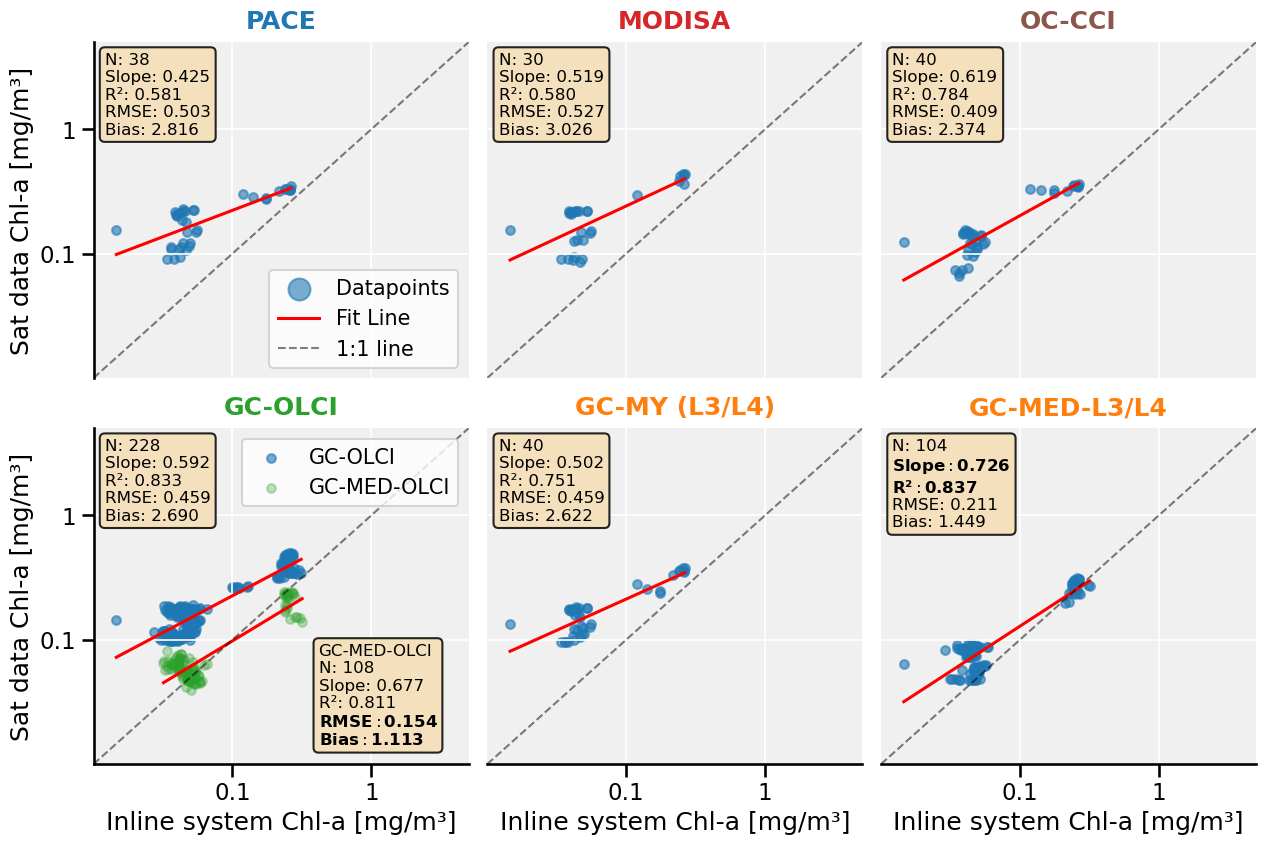

In [20]:
def valid_pos(a):
    """Return finite, positive values from array-like (for log10)."""
    a = np.asarray(a)
    return a[np.isfinite(a) & (a > 0)]

def paired_log10(x_sat, y_inline):
    #note: I have reversed the order in the plotting code (x-axis: inline system, y-axis: satellite data)
    """Return matched, finite log10 pairs (x_log, y_log)."""
    x = valid_pos(x_sat)
    y = valid_pos(y_inline)
    # assume arrays are already matched by index/time; align by mask of finite>0 on both
    m = np.isfinite(x_sat) & (x_sat > 0) & np.isfinite(y_inline) & (y_inline > 0)
    x = np.log10(np.asarray(x_sat)[m])
    y = np.log10(np.asarray(y_inline)[m])
    return x, y

def regression_and_metrics(x_log, y_log):
    """OLS in log space + custom metrics (also in log space)."""
    if len(x_log) < 2:
        return dict(n=len(x_log), slope=np.nan, intercept=np.nan, r2=np.nan,
                    p=np.nan, stderr=np.nan, rmse=np.nan, mdad=np.nan, bias=np.nan)
    slope, intercept, r, p, stderr = stats.linregress(x_log,y_log)
    diff = y_log - x_log
    rmse = float(np.sqrt(np.mean(diff**2)))
    mdad = float(10 ** (np.median(np.abs(diff))))
    bias = float(10 ** (np.mean(diff)))
    return dict(n=len(x_log), slope=slope, intercept=intercept, r2=r**2,
                p=p, stderr=stderr, rmse=rmse, mdad=mdad, bias=bias)

def stats_box_poster2(ax, stats_dict, xpos=0.03, ypos=0.97, extra=None,
              fontsize=14, highlights=None):
    """
    Draw stats box. `highlights` is an iterable of metric names to bold:
      {'slope', 'r2', 'rmse', 'bias'}.

    If N==0 or metric is NaN/inf -> 'no-data'.
    """
    def fmt(label, key):
        v = stats_dict.get(key, np.nan)
        n = stats_dict.get('n', 0)
        if n < 1 or not np.isfinite(v):
            return f"{label}: no-data"
        val_str = f"{v:.3f}"
        if highlights and key in highlights:
            # bold the number via mathtext
            #return f"{label}: $\\mathbf{{{val_str}}}$"
            return f"$\\mathbf{{{label}}}: \\mathbf{{{val_str}}}$"
        else:
            return f"{label}: {val_str}"

    lines = []
    if extra is not None:
        lines.append(extra)
    lines.append(f"N: {stats_dict.get('n', 0)}")
    lines.append(fmt("Slope", "slope"))
    lines.append(fmt("R²",    "r2"))
    lines.append(fmt("RMSE",  "rmse"))
    lines.append(fmt("Bias",  "bias"))

    txt = "\n".join(lines)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.85)
    ax.text(xpos, ypos, txt, transform=ax.transAxes, va='top', ha='left',
            fontsize=fontsize, bbox=props)
    
colors = {
    "PACE":   "#1f77b4",
    "MODISA": "#d62728",
    "OC-CCI": 'tab:brown',
    "GC-OLCI":"#2ca02c",
    "GC-MY":  "#ff7f0e",
    "GC-L4":  "tab:purple",
    "GC-MED-L3":"#ff7f0e",
    "GC-MED-L4":"tab:purple",
    "GC-MED-OLCI":"#2ca02c",
}

data_dic={
'PACE':[[ds_pace,inline_b_pace]],
'MODISA':[[ds_modisa,inline_b_modisa]],
'OC-CCI':[[ds_oc_cci,inline_oc_cci]],
#"GC-OLCI":[[ds_l3olci,inline_b_olci],[ds_gc_olci_l3_interp,inline_gc_olci_l3_interp]],
"GC-OLCI":[[ds_l3olci,inline_b_olci],[ds_gc_med_olci_l3,inline_gc_med_olci_l3]],
"GC-MY":[[ds_l3,inline_b_l3]],    
#"GC-L4":[[ds_l4,inline_b_l4]],
"GC-MED-L3":[[ds_gc_med_l3,inline_gc_med_l3]],
#"GC-MED-L4":[[ds_gc_med_l4,inline_gc_med_l4]],
}

time=time_windows['Med. Sea'][0]

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15/40*25), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05, hspace=0.15)

# style knobs
pt_color   = "#1f77b4"    # datapoints (blue)
fit_color  = 'red' #"#7f7f7f"    # fit line (grey)
oneone_kw  = dict(color="black", ls="--", lw=1.5, alpha=0.5)
lw_fit     = 2.2
s_pts      = 40
alpha_pts  = 0.6

# axis limits & ticks in log10 space
xylims = (-2, 0.7)
tick_pos = [-1, 0, 1]
tick_lab = ['0.1', '1', '10']  # labels shown for log10 ticks

stats_dict={}

highlight_map = {
    'PACE':   set(),          # example
    'MODISA': set(),
    'OC-CCI': set(),
    'GC-OLCI': set(),                   # nothing bold
    'GC-MY':  set(),
    'GC-MED-L3':  {'slope','r2'},                   # main L4
}

# column titles (dataset names, color matched)
for i, (k,v) in enumerate(data_dic.items()):
    ax=axes.flatten()[i]
    
    for ii,(sat_ds,ini_ser) in enumerate(v):


        mask0=(ini_ser['time']>=pd.to_datetime(time[0])) & (ini_ser['time']<pd.to_datetime(time[1]))

        ini_ser=ini_ser.isel(time=mask0.values)
        sat_ds=sat_ds.isel(time=mask0.values)
        
        mask_cv=sat_ds['filt_cv']<0.15
        
        sat = sat_ds['filt_m'][mask_cv]
        ini = ini_ser.isel(time=mask_cv.values)

        # time selection
        #mtime = (ini['time'] >= t0) & (ini['time'] < t1)
        #sat = sat[mtime]
        #ini = ini[mtime]
                # optional daytime filter
        if timefilt:
            tmask = (ini['time'].dt.hour >= 10) & (ini['time'].dt.hour <= 14)
            sat = sat.isel(time=tmask.values)
            ini = ini.isel(time=tmask.values)

        # --- build log10 pairs: y = SAT, x = INLINE
        x_log, y_log = paired_log10(ini.values,sat.values)
        # regression & metrics
        st = regression_and_metrics(x_log, y_log)
        # scatter
        if ii==1:
            stats_dict[k+'*']=st
        else:
            stats_dict[k]=st
        
        #if ii==0:
        
        if i==3 and ii==0:
            ax.scatter(x_log, y_log, s=s_pts, alpha=alpha_pts, label='GC-OLCI',color='tab:blue')
        elif i==3 and ii==1:
            ax.scatter(x_log, y_log, s=s_pts, alpha=(alpha_pts*0.5), label='GC-MED-OLCI',color='tab:green')
        else:
            ax.scatter(x_log, y_log, s=s_pts, alpha=alpha_pts, label='Datapoints',color='tab:blue')
    
        
        # Fit line limited to actual scatter data range
        if np.isfinite(st['slope']):
            # get the finite range of observed x values
            xline = np.linspace(np.nanmin(x_log), np.nanmax(x_log), 100)
            yline = st['slope'] * xline + st['intercept']
            #if ii==0:
            if i==3 and ii==1:
                ax.legend(title=None, fontsize=15, loc='upper right',markerscale=1)
            if i==3 and ii==0:
                label=None
            else:
                label='Fit Line'
            
            ax.plot(xline, yline, lw=lw_fit, color=fit_color, label=label)

            if ii==1 and i==3:
                #stats_box_poster2(ax, st,xpos=0.6,ypos=0.36,extra='@4km resolution',fontsize=12)
                stats_box_poster2(ax, st,xpos=0.6,ypos=0.36,extra='GC-MED-OLCI',fontsize=12,highlights=('rmse','bias'))
            else:
                #if k=='GC-OLCI':
                #    stats_box(ax, st,xpos=0.6,ypos=0.77)
                #else:
                stats_box_poster2(ax, st,fontsize=12,highlights=highlight_map[k]) #,xpos=0.6,ypos=0.37

    ax.plot(xylims, xylims, **oneone_kw, label='1:1 line')
    ax.set_xlim(xylims)
    ax.set_ylim(xylims)
    ax.xaxis.set_major_locator(FixedLocator(tick_pos))
    ax.yaxis.set_major_locator(FixedLocator(tick_pos))
    ax.xaxis.set_major_formatter(FixedFormatter(tick_lab))
    ax.yaxis.set_major_formatter(FixedFormatter(tick_lab))
    if k=='GC-MY':
        ax.set_title('GC-MY (L3/L4)', color=colors[k], fontweight='bold', fontsize=18, pad=10)
    elif k=='GC-MED-L3':
        ax.set_title('GC-MED-L3/L4', color=colors[k], fontweight='bold', fontsize=18, pad=10)
    else:
        ax.set_title(k, color=colors[k], fontweight='bold', fontsize=18, pad=10)
    ax.set_facecolor("#F0F0F0")
    ax.grid(True, color="white", linewidth=1.2)

    for side in ('top','right'):
        ax.spines[side].set_visible(False)
    if i %3!= 0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y',length=0)
        ax.set_ylabel('', fontsize=11)
    else:
        ax.set_ylabel('Sat data Chl-a [mg/m³]')
    
    if i < 3:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='x',length=0)
        ax.set_xlabel('', fontsize=11)
    else:
        ax.set_xlabel('Inline system Chl-a [mg/m³]')

    #if i == 2:
    #    ax.legend(title=None, fontsize=15, loc='upper right',bbox_to_anchor=(1.55,1),markerscale=2.5)
    if i==0:
        ax.legend(title=None, fontsize=15, loc='lower right',markerscale=2.5)


#fig.suptitle(r'Statistics of global and regional satellite datasets - Mediterranean Sea',fontsize=25) 
fig.savefig('stats_med_sea_poster.png',dpi=600,bbox_inches='tight')

In [255]:
stats_dict

{'PACE': {'n': 38,
  'slope': np.float64(0.42460550627016524),
  'intercept': np.float64(-0.2273721924328686),
  'r2': np.float64(0.5807468736243053),
  'p': np.float64(2.725482010198198e-08),
  'stderr': np.float64(0.06012832226202553),
  'rmse': 0.503208010978455,
  'mdad': 2.707122366643306,
  'bias': 2.815680657486653},
 'MODISA': {'n': 30,
  'slope': np.float64(0.5190794258197104),
  'intercept': np.float64(-0.098078869126216),
  'r2': np.float64(0.5798898697431043),
  'p': np.float64(1.0231522509255821e-06),
  'stderr': np.float64(0.083495604992674),
  'rmse': 0.5270080514782598,
  'mdad': 2.7141074272771277,
  'bias': 3.026248406233724},
 'OC-CCI': {'n': 40,
  'slope': np.float64(0.6185226588315316),
  'intercept': np.float64(-0.0763806725431132),
  'r2': np.float64(0.7843731137940971),
  'p': np.float64(3.157530612310657e-14),
  'stderr': np.float64(0.052608258089621565),
  'rmse': 0.40942892202431125,
  'mdad': 2.301834403968041,
  'bias': 2.373747102281123},
 'GC-OLCI': {'n':

In [275]:
stats_dict.pop('GC-MED-L4');stats_dict.pop('GC-L4')

{'n': 40,
 'slope': np.float64(0.5021485496796112),
 'intercept': np.float64(-0.17095415594372332),
 'r2': np.float64(0.7506611905220196),
 'p': np.float64(5.092592228192572e-13),
 'stderr': np.float64(0.04694759760371176),
 'rmse': 0.45891526134803895,
 'mdad': 2.603719081320842,
 'bias': 2.6224124785549976}

In [276]:
pd.DataFrame(stats_dict).style.apply(highlight_best_worst,axis=1).format(precision=3)

,PACE,MODISA,OC-CCI,GC-OLCI,GC-OLCI*,GC-MY,GC-MED-OLCI,GC-MED-L3
n,38.000,30.000,40.000,228.000,39.000,40.000,108.000,104.000
slope,0.425,0.519,0.619,0.592,0.530,0.502,0.677,0.726
intercept,-0.227,-0.098,-0.076,-0.055,-0.124,-0.171,-0.333,-0.165
r2,0.581,0.580,0.784,0.833,0.820,0.751,0.811,0.837
p,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
stderr,0.060,0.083,0.053,0.018,0.041,0.047,0.032,0.032
rmse,0.503,0.527,0.409,0.459,0.469,0.459,0.154,0.211
mdad,2.707,2.714,2.302,2.760,2.774,2.604,1.240,1.349
bias,2.816,3.026,2.374,2.690,2.728,2.622,1.113,1.449


In [277]:
print_latex(pd.DataFrame(stats_dict))

\begin{table}[htbp]
\centering
\caption{Statistical comparison across datasets}
\label{tab:dataset_comparison}
\begin{tabular}{lrrrrrrrr}
\hline
Metric & PACE & MODISA & OC-CCI & GC-OLCI & GC-OLCI* & GC-MY & GC-MED-OLCI & GC-MED-L3 \\
\hline
n & 38 & 30 & 40 & 228 & 39 & 40 & 108 & 104 \\
Slope & \textit{0.425} & 0.519 & 0.619 & 0.592 & 0.530 & 0.502 & 0.677 & \textbf{0.726} \\
Intercept & -0.227 & -0.098 & -0.076 & \textbf{-0.055} & -0.124 & -0.171 & \textit{-0.333} & -0.165 \\
R$^2$ & 0.581 & \textit{0.580} & 0.784 & 0.833 & 0.820 & 0.751 & 0.811 & \textbf{0.837} \\
RMSE & 0.503 & \textit{0.527} & 0.409 & 0.459 & 0.469 & 0.459 & \textbf{0.154} & 0.211 \\
MdAD & 2.707 & 2.714 & 2.302 & 2.760 & \textit{2.774} & 2.604 & \textbf{1.240} & 1.349 \\
Bias & 2.816 & \textit{3.026} & 2.374 & 2.690 & 2.728 & 2.622 & \textbf{1.113} & 1.449 \\
\hline
\end{tabular}
\end{table}


LaTeX table generated successfully!
Best values are highlighted in bold, worst values in italics.


# 2. Inline system, distribution of values (12+-2 hours vs the rest) + regional difference
* 2 by 2 plot with N, medians and 5,50,95 quantile

Text(0.5, 0.95, 'Distribution of Inline system Chl-a values (q5|q50|q95)')

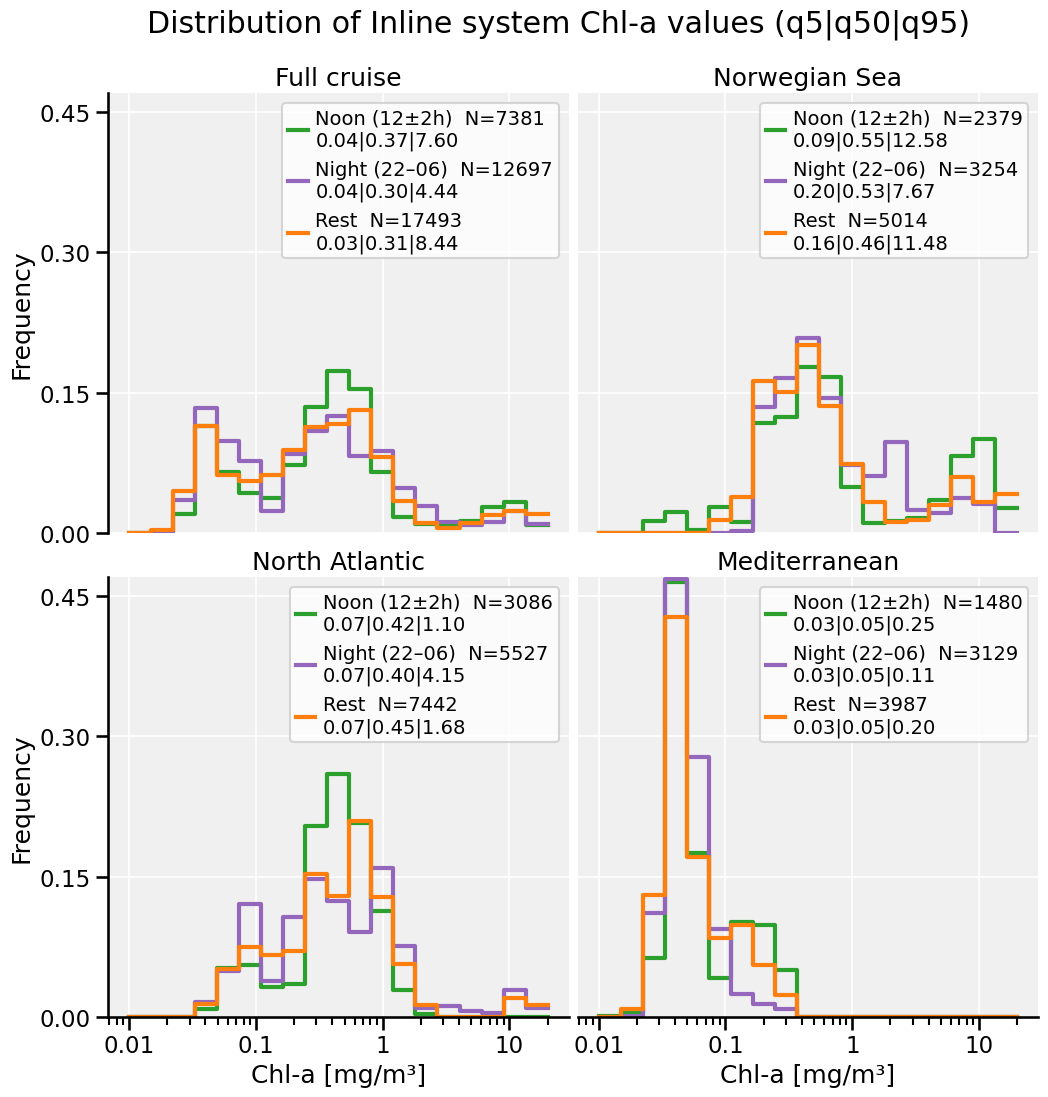

In [239]:
from matplotlib.ticker import MaxNLocator

data = inline['CHL']

# --- three time windows
hrs = data['time'].dt.hour
mask_noon  = ((hrs >= 10) & (hrs <= 14)).values          # 12pm ± 2h
mask_night = ((hrs >= 22) | (hrs < 6)).values            # 22:00–06:00 (wraps midnight)
mask_rest  = (~(mask_noon | mask_night))                 # everything else

time_windows = {
    'Full cruise': ["2025-04-20", "2025-06-04"],
    'Norwegian Sea': ["2025-04-20", "2025-05-04"],
    'North Atlantic': ["2025-05-05", "2025-05-24"],
    'Mediterranean': ["2025-05-25", "2025-06-04"],
}

colors = {
    "Noon (12±2h)" : "tab:green",
    "Night (22–06)": "tab:purple",
    "Rest"         : "tab:orange",
}

lw = 3
xmin, xmax = 1e-2, 20
nbins = 20
bins = np.logspace(np.log10(xmin), np.log10(xmax), nbins)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12), sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.1)

for i, (title, (t0, t1)) in enumerate(time_windows.items()):
    ax = axes.flatten()[i]

    start = pd.to_datetime(t0)
    end   = pd.to_datetime(t1)

    for mask, label in zip([mask_noon, mask_night, mask_rest],
                           ["Noon (12±2h)", "Night (22–06)", "Rest"]):
        da = data.isel(time=mask)
        sel = (da['time'] >= start) & (da['time'] <= end)
        da  = da.isel(time=sel.values)

        x = np.asarray(da.values).ravel()
        x = x[np.isfinite(x) & (x > 0)]  # safe for log-x

        # Quantiles for the legend (5|50|95)
        if x.size:
            q5, q50, q95 = np.nanpercentile(x, [5, 50, 95])
            leg = f"{label}  N={x.size}\n{q5:.2f}|{q50:.2f}|{q95:.2f}"
        else:
            leg = f"{label}  N=0\n–|–|–"

        sns.histplot(
            x, bins=bins, stat='probability', element='step',
            fill=False, lw=lw, ax=ax, color=colors[label], label=leg
        )

    # Axes styling
    ax.set_xscale("log")
    ax.set_xticks([0.01, 0.1, 1, 10])
    ax.set_xticklabels([0.01, 0.1, 1, 10])
    ax.set_ylim([0, 0.47])
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))  # fewer y-ticks

    ax.set_facecolor("#F0F0F0")
    ax.grid(True, color="white", linewidth=1.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i < 2:
        ax.spines['bottom'].set_visible(False)
        ax.set_xticklabels('')
        ax.tick_params(axis='x', length=0, which='both')
    else:
        ax.set_xlabel('Chl-a [mg/m³]')

    if i % 2 != 0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', length=0)
    else:
        ax.set_ylabel('Frequency')

    ax.set_title(title)

    # One legend per subplot, in the open space
    ax.legend(loc='upper right', fontsize=14, handlelength=1.0,
              frameon=True, borderpad=0.3, handletextpad=0.4)

fig.suptitle('Distribution of Inline system Chl-a values (q5|q50|q95)', y=0.95)


In [ ]:
# --- your setup stays the same
timefilt = True

dicti = {
    'PACE':   [ds_pace,   inline_b_pace],
    'MODISA': [ds_modisa, inline_b_modisa],
    'GC-OLCI':[ds_l3olci, inline_b_olci],
    'GC-MY':  [ds_l3,     inline_b_l3],
    'GC-L4':  [ds_l4,     inline_b_l4],
}

colors = {
    "PACE":   "#1f77b4",
    "MODISA": "#d62728",
    "GC-OLCI":"#2ca02c",
    "GC-MY":  "#ff7f0e",
    "GC-L4":  "#9467bd",
}

lw = 3
xmin, xmax = 1e-2, 20
nbins = 20
bins = np.logspace(np.log10(xmin), np.log10(xmax), nbins)

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(26, 17), sharey=True)
# a little breathing room horizontally; keep rows reasonably tight
plt.subplots_adjust(wspace=0.05, hspace=0.13)

# column titles (color-matched)
for i, k in enumerate(dicti.keys()):
    axes[0, i].set_title(k, color=colors[k], fontweight='bold', fontsize=14, pad=10)

region_labels = ['Full cruise', 'Norwegian Sea', 'North Atlantic', 'Med. Sea']

for ii, timesels in enumerate([
    ["2025-04-20","2025-06-04"],
    ["2025-04-20","2025-05-04"],
    ["2025-05-05","2025-05-24"],
    ["2025-05-25","2025-06-04"]
]):

    for i, (k, [sat, ini]) in enumerate(dicti.items()):
        ax = axes[ii][i]

        # --- style: light grey background; no grid; slim down spines
        #ax.set_facecolor("#f7f7f7")
        #ax.grid(False)
        ax.set_facecolor("#F0F0F0")

        # White gridlines, thin and subtle
        ax.grid(True, color="white", linewidth=1.2)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # hide left spine except in first column to reduce clutter
        if i != 0:
            ax.spines['left'].set_visible(False)

        # --- data filters
        mask = sat['filt_cv'] < 0.15
        sat = sat['filt_m'][mask]
        ini = ini[mask]
        inline_full = inline['CHL']

        # region time selection
        t0, t1 = pd.to_datetime(timesels[0]), pd.to_datetime(timesels[1])
        maski = (ini['time'] >= t0) & (ini['time'] <= t1)
        sat = sat[maski]
        ini = ini[maski]
        maski2 = (inline_full['time'] >= t0) & (inline_full['time'] <= t1)
        inline_full = inline_full[maski2]

        # day-time window
        if timefilt:
            tmask  = (ini['time'].dt.hour >= 10) & (ini['time'].dt.hour <= 14)
            sat = sat[tmask]
            ini = ini[tmask]
            tmask2 = (inline_full['time'].dt.hour >= 10) & (inline_full['time'].dt.hour <= 14)
            inline_full = inline_full[tmask2]

        # --- inline (main comparator)
        q25, q50, q75 = np.nanquantile(ini.values, [0.25, 0.5, 0.75])
        label_full = f"Inline\n{q25:.2f}|{q50:.2f}|{q75:.2f}"
        sns.histplot(
            ini.values, bins=bins, stat='probability', element='step',alpha=0.2,
            fill=True, lw=lw, label=label_full, ax=ax, color='black'
        )
        
        # --- satellite dist + quantiles in 2-line label (kept)
        q25, q50, q75 = np.nanquantile(sat.values, [0.25, 0.5, 0.75])
        label_full = f"{k} N={len(sat[~np.isnan(sat)])} \n{q25:.2f}|{q50:.2f}|{q75:.2f}"
        sns.histplot(
            sat.values, bins=bins, stat='probability', element='step',
            fill=False, lw=lw, label=label_full, ax=ax, color=colors[k]
        )

        # --- inline-full: only in the first column; de-emphasized
        if i == 0:
            q25, q50, q75 = np.nanquantile(inline_full, [0.25, 0.5, 0.75])
            label_full = f"Inline-full N={len(inline_full[~np.isnan(inline_full)])} \n{q25:.2f}|{q50:.2f}|{q75:.2f}"
            sns.histplot(
                inline_full, bins=bins, stat='probability', element='step',
                fill=False, lw=2, label=label_full, ax=ax, color='black',
                alpha=0.35, linestyle=':', dashes=(1, 1)
            )

        # --- axes
        ax.set_xscale("log")
        ax.set_xticks([0.01, 0.1, 1, 10])
        ax.set_xticklabels([0.01, 0.1, 1, 10])
        ax.set_ylim([0, 0.7])
        ax.set_ylabel('')  # keep clean; shared y-scale already communicates

        if i>0:
            ax.tick_params(axis='y',length=0)
        
        # Get the legend handles and labels
        handles, labels = ax.get_legend_handles_labels()
        
        # Create a new list of handles where we modify the inline data handle
        new_handles = []
        for handle, label in zip(handles, labels):
            if 'Inline' in label and 'full' not in label:  # Main inline data (not the full one)
                # Create a simple Line2D object without marker, just a black line
                new_handle = plt.Line2D([0], [0], color='black', linewidth=lw)
                new_handles.append(new_handle)
            else:
                new_handles.append(handle)
        
        # Create legend with the modified handles
        ax.legend(
            new_handles, labels,
            fontsize=11, handlelength=0.8, handletextpad=0.3, borderpad=0.2,
            frameon=True, loc='upper right'
        )

    # clearer row labels, bold & centered on row
    axes[ii, 0].text(
        -0.25, 0.5, region_labels[ii],
        transform=axes[ii, 0].transAxes,
        va='center', ha='right', fontweight='bold', fontsize=18
    )

fig.suptitle(
    'Inline–Satellite Chl-a distributions [mg/m³] (q25|q50|q75) — 2h around noon',
    y=0.93, fontsize=20
)
